In [2]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#import warnings
#warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In this notebook, I plan to do the following:

1. Run Ridge/Lasso regression on engineered2 features
2. Try ExtraTrees regression
3. Try Gradient Boosting on polynomial features
4. Try regression on polynomial features
5. Try stacking or meta ensemble
6. Add features like median price based on the neighborhood and use it in stacking if useful
7. Analyze residuals for all the above cases!
8. Try other techniques like xgboost using linear and tree booster

## Load in the Data

Below data files are produced using the notebook below:
https://github.com/ptiwaree/Kaggle-HousePrices/blob/master/House%20Prices%20-%20Feature%20Engineering-2.ipynb

In [3]:
train = pd.read_csv('train_engineered2.csv')
test = pd.read_csv('test_engineered2.csv')
output = pd.read_csv('log_SalePrice2.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1460, 299) (1459, 299) (1460, 1)


In [4]:
train.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

In [5]:
output.head(2)

log_SalePrice
0      12.247699
1      12.109016

## Data Analysis

In [6]:
train.columns.shape[0]

299

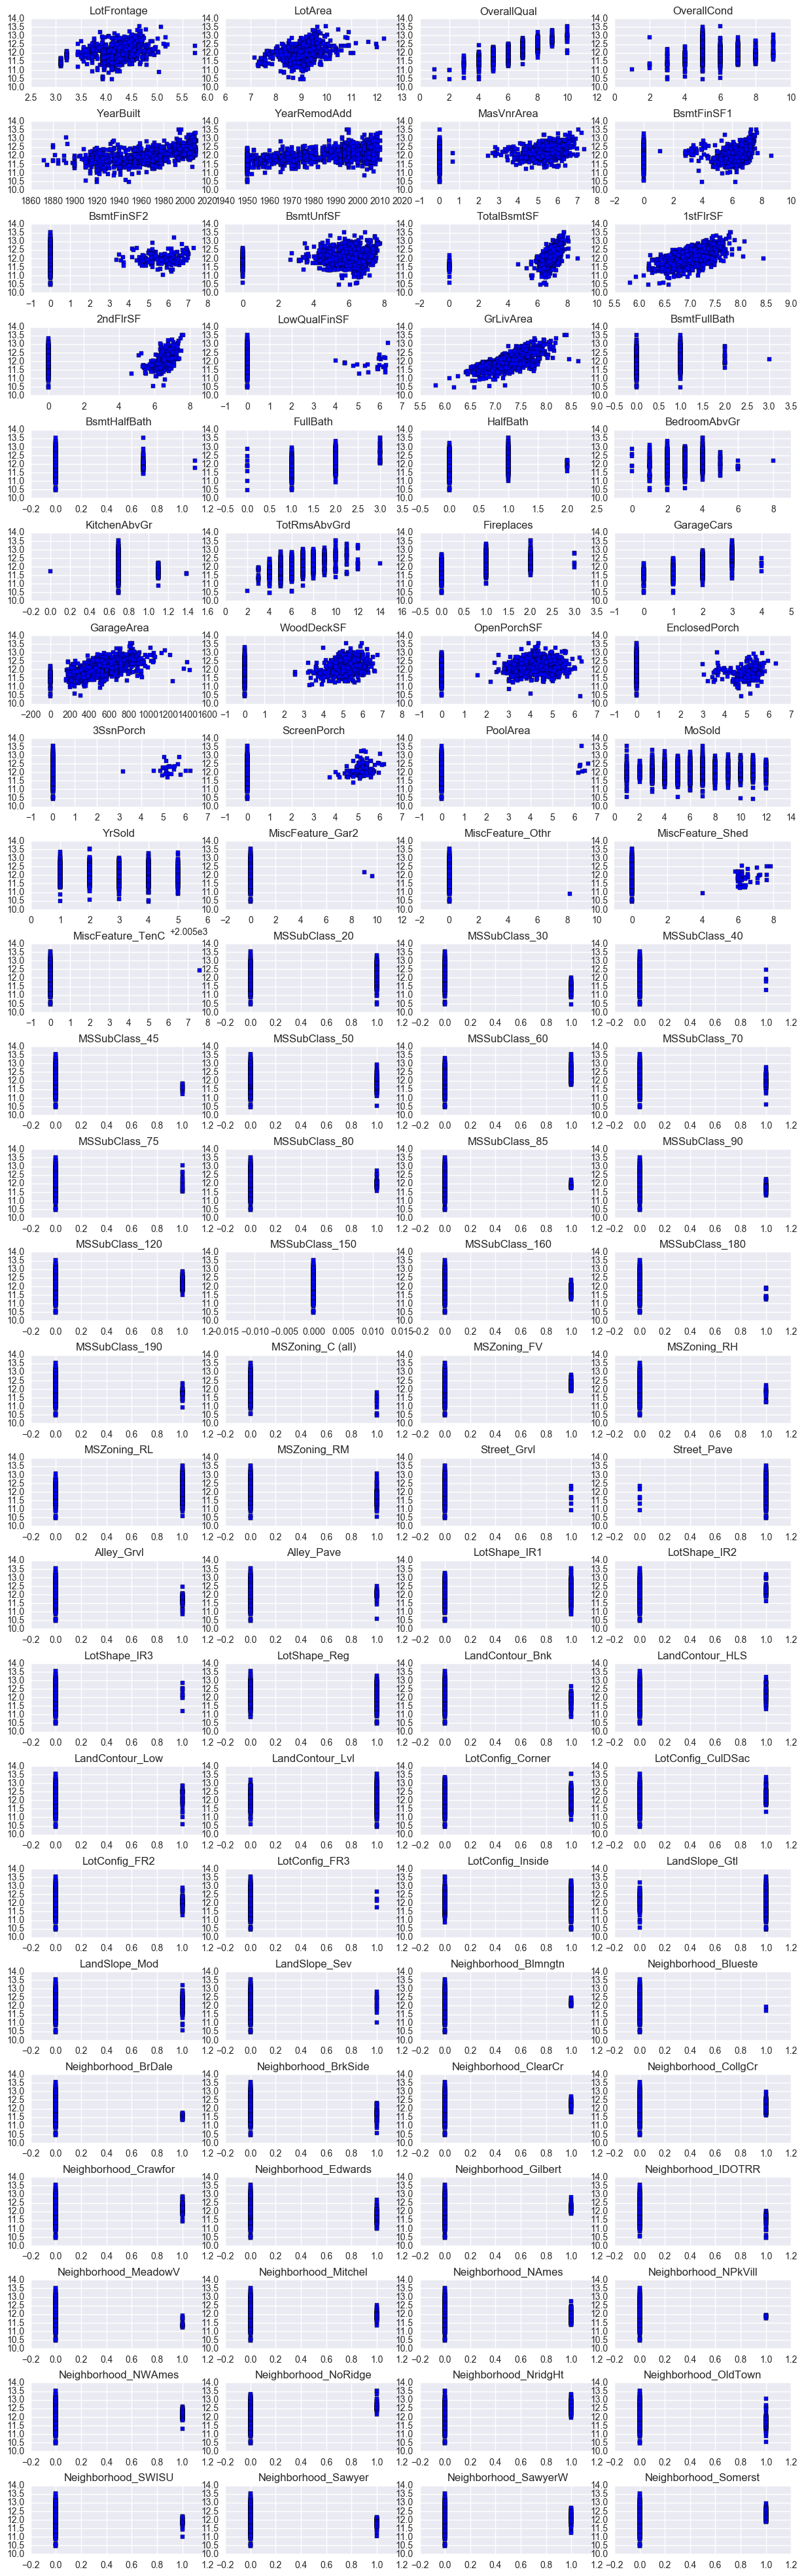

In [7]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i])

Looking at the above graph, we could potentially use polynomial features to improve results. Features like TotalBsmtSF could benefit from it. Other features that we could use polynomial transformation are:

MasVnrArea,
BsmtFinSF1,
BsmtFinSF2,
BsmtUnfSF,
TotalBsmtSF,
2ndFlrSF,
LowQualFinSF,
WoodDeckSF,
EnclosedPorch,
3SsnPorch,
ScreenPorch,
YrSold,
MiscFeature_Shed

In [8]:
train.shape

(1460, 299)

### Remove outliers

In [9]:
train.LotFrontage.sort_values(ascending=False).head(5)

934     5.749393
1298    5.749393
1127    5.209486
231     5.164786
197     5.164786
Name: LotFrontage, dtype: float64

In [10]:
index2include = train[train.LotFrontage < 5.209486].index
index2include

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1457)

In [11]:
train.loc[index2include, :].shape

(1457, 299)

In [12]:
train = train.loc[index2include, :] #remove LotFrontage outliers

In [13]:
output = output.loc[index2include, :] #remove LotFrontage outliers

In [14]:
train.shape, output.shape

((1457, 299), (1457, 1))

In [15]:
train.LotArea.sort_values(ascending=False).head(5)

313    12.279537
335    12.011644
249    11.976666
706    11.653991
451    11.167077
Name: LotArea, dtype: float64

In [16]:
index2include = train[train.LotArea < 11.167077].index

In [17]:
train = train.loc[index2include, :] #remove LotArea outliers
output = output.loc[index2include, :] #remove LotArea outliers
train.shape, output.shape

((1452, 299), (1452, 1))

In [18]:
train.TotalBsmtSF.sort_values(ascending=False).head(5)

332     8.073091
496     8.071219
523     8.051660
440     8.037543
1373    7.876259
Name: TotalBsmtSF, dtype: float64

In [19]:
index2include = train[train.TotalBsmtSF < 8.037543].index #remove TotalBsmtSF outliers

In [20]:
train = train.loc[index2include, :] #remove TotalBsmtSF outliers
output = output.loc[index2include, :] #remove TotalBsmtSF outliers
train.shape, output.shape

((1448, 299), (1448, 1))

In [21]:
train['1stFlrSF'].sort_values(ascending=False).head(5)

1024    7.972121
1373    7.876259
1044    7.833996
529     7.830426
691     7.801800
Name: 1stFlrSF, dtype: float64

In [22]:
train['GrLivArea'].sort_values(ascending=False).head(5)

1182    8.406708
691     8.370316
1169    8.196437
185     8.191186
304     8.158802
Name: GrLivArea, dtype: float64

In [23]:
index2include = train[train.GrLivArea < 8.191186].index #remove GrLivArea outliers

In [24]:
train = train.loc[index2include, :] #remove GrLivArea outliers
output = output.loc[index2include, :] #remove GrLivArea outliers
train.shape, output.shape

((1444, 299), (1444, 1))

In [25]:
train['GarageArea'].sort_values(ascending=False).head(5)

581     1390.0
1190    1356.0
1061    1248.0
825     1220.0
178     1166.0
Name: GarageArea, dtype: float64

In [26]:
index2include = train[train.GarageArea < 1166.0].index #remove GarageArea outliers

In [27]:
train = train.loc[index2include, :] #remove GarageArea outliers
output = output.loc[index2include, :] #remove GarageArea outliers
train.shape, output.shape

((1439, 299), (1439, 1))

### Lets look into output variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e7cdf50>]], dtype=object)

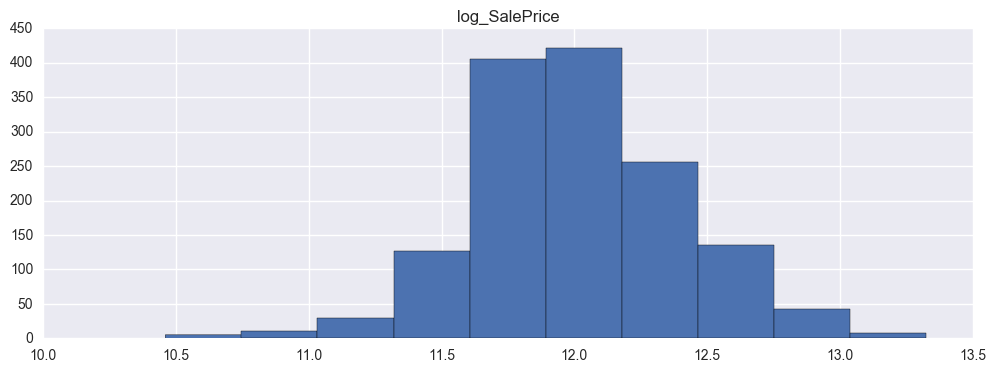

In [28]:
output.hist()

It looks a bit skewed so lets drop some extreme values.

In [29]:
output['log_SalePrice'].sort_values(ascending=True).head(20)

495     10.460271
916     10.471978
968     10.542733
533     10.579005
30      10.596660
710     10.859018
1337    10.868587
1325    10.915107
705     10.915107
812     10.933000
1380    10.976799
1100    11.002117
636     11.002117
410     11.002117
375     11.018646
462     11.041064
1432    11.074436
874     11.104972
398     11.112463
620     11.112463
Name: log_SalePrice, dtype: float64

In [30]:
index2include = output[output.log_SalePrice > 10.596660].index #remove output outliers

In [31]:
train = train.loc[index2include, :] #remove output outliers
output = output.loc[index2include, :] #remove output outliers
train.shape, output.shape

((1434, 299), (1434, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e40b350>]], dtype=object)

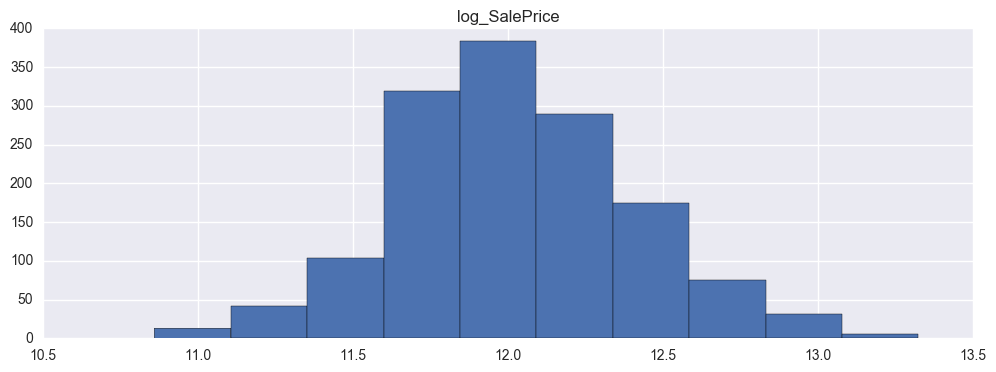

In [32]:
output.hist()

Output looks better! Now lets keep exploring the rest of the input variables!

In [393]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i+100]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i+100])

In [394]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(99):
    axs[i].scatter(train[train.columns[i+200]].values, output.values, c = "blue", marker = "s")
    axs[i].set_title(train.columns[i+200])

We can see that several variables have a trend line so they are likely to be good predictors!

## Modeling

### Lets start with Ridge Regression

In [46]:
def modelfit(model, dtrain, features, output, validation, validation_output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    validation_predictions = model.predict(validation[features])

    
    #Perform cross-validation:
    from sklearn.model_selection import cross_val_score
    from sklearn import metrics
    if performCV:
        cv_score = cross_val_score(model, dtrain[features], output, cv=cv_folds)
        cv_score_mse = cross_val_score(model, dtrain[features], output, cv=cv_folds, scoring='neg_mean_squared_error')
        
    
    #Print model report:
    print "\nModel Report"
    print "Training R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "Training RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))    
    print "Validation R-Square: %.3f" % metrics.r2_score(validation_output, validation_predictions)
    print "Validation RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(validation_output, validation_predictions))
    print('Variance score: %.2f' % model.score(validation, validation_output))
    print('Optimal Alpha: %.4f') %model.alpha_ 
    
    if performCV:
        print"Training cv_score (R^2 and MSE):  "
        print(cv_score)
        print(cv_score_mse)
        print "CV Score (R^2) : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        print "CV Score (MSE) : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score_mse),np.std(cv_score_mse),np.min(cv_score_mse),np.max(cv_score_mse))

    if printFeatureImportance:
        df = {'features': features.values, 'Coefficients': model.coef_[0]}
        coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
        plt.figure()
        coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
        plt.ylabel('Feature Coefs')
        plt.figure()
        coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
        plt.ylabel('Feature Coefs')

In [40]:
from sklearn import linear_model

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=27)

In [42]:
features = X_train.columns

In [43]:
alpha = 10**np.random.uniform(-1,1, size=100)
print alpha

[ 0.43403628  5.83911668  8.53968869  0.20400708  0.56268332  1.1350257
  0.10495515  1.25297569  0.23724362  6.17674034  0.73989508  4.64720062
  0.87479818  0.13052617  0.21463088  1.12551292  0.30780862  0.15208376
  0.17851185  2.72956181  0.64972795  0.55682212  5.8207515   5.30641486
  0.52595518  9.15591908  0.12425742  3.75637778  0.50885776  1.37812611
  4.79913813  0.80150078  0.72232243  2.53240835  2.21943619  0.28577528
  0.94930718  4.77458312  0.72943524  0.48636442  0.13238483  0.23042494
  7.01694255  0.58066605  0.21261648  0.10030226  0.67201358  0.41324147
  0.75300579  0.38829698  0.10345228  0.39801986  6.66612704  3.1266261
  0.55193227  1.70535468  2.82191213  0.5399133   1.03772791  0.15045266
  2.82720205  6.72331347  7.63977249  9.43859498  1.90597923  0.41299529
  2.22325038  3.45702175  0.264349    0.13419062  8.88391692  0.11997937
  4.86370801  0.29193163  3.24658245  8.54684678  0.78462481  2.27689208
  0.24251738  1.5914957   8.3067328   2.83720568  0.6

In [44]:
ridge = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)


Model Report
Training R-Square: 0.945
Training RMSE : 0.089
Validation R-Square: 0.914
Validation RMSE : 0.110
Variance score: 0.91
Optimal Alpha: 9.4386
Training cv_score (R^2 and MSE):  
[ 0.9029167   0.92798793  0.918259    0.93117182  0.91160402]
[-0.01150533 -0.00992557 -0.01268376 -0.01135619 -0.01277677]
CV Score (R^2) : Mean: 0.9183879 | Std: 0.01040178 | Min: 0.9029167 | Max: 0.9311718
CV Score (MSE) : Mean: -0.01164952 | Std: 0.001041075 | Min: -0.01277677 | Max: -0.009925567


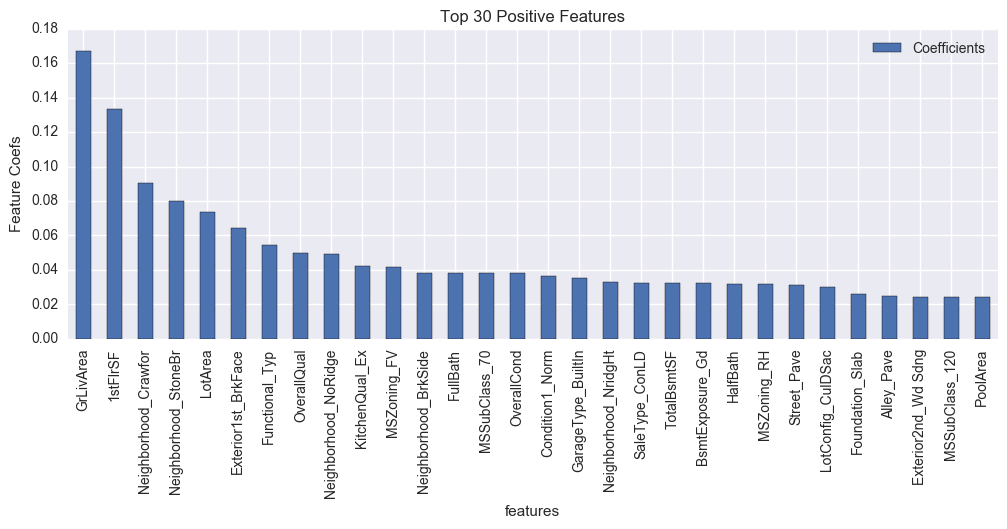

In [47]:
modelfit(ridge, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=True)

In [48]:
# The coefficients
df = {'features': features, 'Coefficients': ridge.coef_[0]}
ridge_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
ridge_coefficients

Coefficients               features
14       0.167221              GrLivArea
11       0.133369               1stFlrSF
84       0.090357   Neighborhood_Crawfor
100      0.080115   Neighborhood_StoneBr
1        0.073564                LotArea
150      0.064501    Exterior1st_BrkFace
249      0.054246         Functional_Typ
2        0.049732            OverallQual
93       0.049384   Neighborhood_NoRidge
239      0.042177         KitchenQual_Ex
54       0.041602            MSZoning_FV
81       0.038288   Neighborhood_BrkSide
17       0.038279               FullBath
43       0.038147          MSSubClass_70
3        0.038051            OverallCond
105      0.036308        Condition1_Norm
258      0.035405     GarageType_BuiltIn
94       0.033121   Neighborhood_NridgHt
287      0.032506         SaleType_ConLD
10       0.032459            TotalBsmtSF
206      0.032229        BsmtExposure_Gd
18       0.031823               HalfBath
55       0.031648            MSZoning_RH
59       0.030968            Street_Pave
71       0.030167      LotConfig_CulDSac
194      0.026305        Foundation_Slab
61       0.025067             Alley_Pave
176      0.024288    Exterior2nd_Wd Sdng
48       0.024267         MSSubClass_120
30       0.024186               PoolArea
..            ...                    ...
198     -0.024152            BsmtQual_Fa
178     -0.024828      MasVnrType_BrkCmn
42      -0.025513          MSSubClass_60
38      -0.026788          MSSubClass_30
90      -0.026820     Neighborhood_NAmes
220     -0.027138       BsmtFinType2_Unf
284     -0.027539           SaleType_COD
265     -0.027700          GarageQual_Fa
92      -0.028043    Neighborhood_NWAmes
50      -0.028043         MSSubClass_160
216     -0.028177       BsmtFinType2_BLQ
208     -0.028715        BsmtExposure_No
103     -0.028743      Condition1_Artery
97      -0.030644    Neighborhood_Sawyer
201     -0.030874            BsmtCond_Fa
58      -0.030968            Street_Grvl
244     -0.032252        Functional_Maj2
86      -0.032412   Neighborhood_Gilbert
144     -0.032434       RoofMatl_Tar&Grv
77      -0.032685          LandSlope_Sev
20      -0.033377           KitchenAbvGr
259     -0.035945     GarageType_CarPort
293     -0.037710  SaleCondition_Abnorml
292     -0.040844            SaleType_WD
108     -0.040983        Condition1_RRAe
160     -0.041984    Exterior1st_Wd Sdng
85      -0.043596   Neighborhood_Edwards
89      -0.045506   Neighborhood_Mitchel
88      -0.058218   Neighborhood_MeadowV
53      -0.068736       MSZoning_C (all)

[299 rows x 2 columns]

In [49]:
ridge_train_predictions = np.expm1(ridge.predict(train[features]))
ridge_test_predictions = np.expm1(ridge.predict(test[features]))

In [53]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(output.values), ridge_train_predictions, c = "white", marker = "s", label = "Training data")
plt.scatter(np.expm1(y_train.values), np.expm1(ridge.predict(X_train[features])), c = "green", marker = ".", label = "X_train")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[features])), c = "red", marker = "x", label = "X_test")

plt.title("Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

### Lets try Lasso

In [54]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)
alpha

array([  1.23842618e-01,   7.34866015e-05,   2.29674055e-01,
         1.75427370e-03,   1.21400346e-05,   4.10636811e-01,
         8.04305310e-02,   9.72336330e-04,   2.30518131e-03,
         9.79986797e-05,   1.21766021e+00,   4.90655992e-01,
         8.09467893e+00,   1.87231870e-04,   4.09210112e-05,
         1.07819234e-06,   6.31483055e-02,   8.53055496e-04,
         2.39480505e-02,   1.11526029e-02,   7.30096147e-06,
         1.80458243e-02,   6.80089883e-01,   2.96354865e+00,
         2.95497966e-02,   3.10970804e-05,   1.55964018e-05,
         2.93601777e-05,   6.36367509e+00,   2.52316084e-05,
         7.92517112e-06,   5.69235577e-01,   5.18372158e-01,
         8.85052261e-06,   1.84730665e-03,   6.39713096e-05,
         5.37659636e-06,   1.31562219e-04,   1.12167534e+00,
         4.16608148e-01,   6.71599318e-05,   4.34056825e-04,
         3.38096760e-01,   6.05719745e-04,   1.24635484e-04,
         1.00614997e-04,   4.30405306e-04,   1.05443859e-05,
         1.40004336e+00,

In [55]:
lasso = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [56]:
modelfit(lasso, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Model Report
Training R-Square: 0.938
Training RMSE : 0.095
Validation R-Square: 0.914
Validation RMSE : 0.111
Variance score: 0.91
Optimal Alpha: 0.0006
Training cv_score (R^2 and MSE):  
[ 0.89883901  0.92964706  0.92326005  0.93088965  0.91484757]
[-0.01198858 -0.00969689 -0.01190774 -0.01140274 -0.01230794]
CV Score (R^2) : Mean: 0.9194967 | Std: 0.01179276 | Min: 0.898839 | Max: 0.9308896
CV Score (MSE) : Mean: -0.01146078 | Std: 0.0009285177 | Min: -0.01230794 | Max: -0.009696886


In [57]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso.coef_}
lasso_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients

Coefficients               features
14       0.349440              GrLivArea
84       0.111982   Neighborhood_Crawfor
100      0.098908   Neighborhood_StoneBr
150      0.080110    Exterior1st_BrkFace
1        0.068872                LotArea
249      0.068345         Functional_Typ
11       0.066767               1stFlrSF
239      0.061280         KitchenQual_Ex
2        0.054782            OverallQual
93       0.051338   Neighborhood_NoRidge
81       0.050521   Neighborhood_BrkSide
206      0.049134        BsmtExposure_Gd
94       0.042721   Neighborhood_NridgHt
3        0.042394            OverallCond
197      0.041272            BsmtQual_Ex
105      0.036547        Condition1_Norm
120      0.033025          BldgType_1Fam
54       0.029655            MSZoning_FV
182      0.027422           ExterQual_Ex
43       0.025046          MSSubClass_70
15       0.022430           BsmtFullBath
227      0.021907           HeatingQC_Ex
17       0.021204               FullBath
99       0.019873   Neighborhood_Somerst
22       0.019636             Fireplaces
48       0.017989         MSSubClass_120
71       0.017897      LotConfig_CulDSac
193      0.017526       Foundation_PConc
10       0.016968            TotalBsmtSF
18       0.015196               HalfBath
..            ...                    ...
62      -0.001855           LotShape_IR1
35      -0.002186       MiscFeature_Shed
72      -0.002512          LotConfig_FR2
60      -0.003003             Alley_Grvl
13      -0.003163           LowQualFinSF
213     -0.003351       BsmtFinType1_Rec
32      -0.003634                 YrSold
172     -0.004212    Exterior2nd_Plywood
208     -0.004491        BsmtExposure_No
88      -0.005097   Neighborhood_MeadowV
19      -0.009371           BedroomAbvGr
34      -0.009601       MiscFeature_Othr
103     -0.009823      Condition1_Artery
47      -0.010870          MSSubClass_90
188     -0.011020           ExterCond_Gd
185     -0.011866           ExterQual_TA
265     -0.011878          GarageQual_Fa
38      -0.013068          MSSubClass_30
284     -0.013804           SaleType_COD
85      -0.014359   Neighborhood_Edwards
160     -0.015126    Exterior1st_Wd Sdng
153     -0.016077    Exterior1st_HdBoard
259     -0.016111     GarageType_CarPort
89      -0.016397   Neighborhood_Mitchel
257     -0.016511     GarageType_Basment
292     -0.036330            SaleType_WD
232     -0.037751           CentralAir_N
57      -0.041830            MSZoning_RM
293     -0.057588  SaleCondition_Abnorml
53      -0.087134       MSZoning_C (all)

[299 rows x 2 columns]

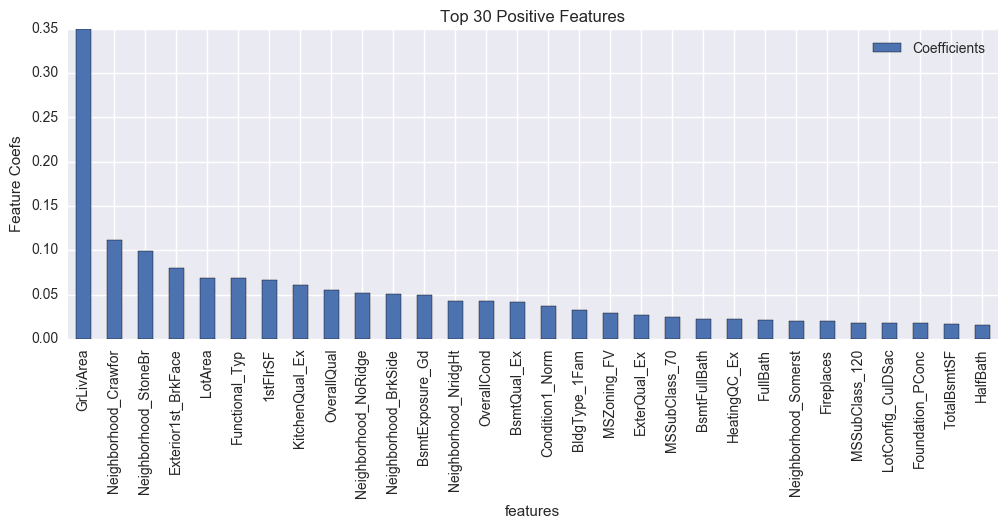

In [61]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

In [63]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(output.values), np.expm1(lasso.predict(train[features])), c = "white", marker = "s", label = "Training data")
plt.scatter(np.expm1(y_train.values), np.expm1(lasso.predict(X_train[features])), c = "green", marker = ".", label = "X_train")
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test[features])), c = "red", marker = "x", label = "X_test")

plt.title("Lasso Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

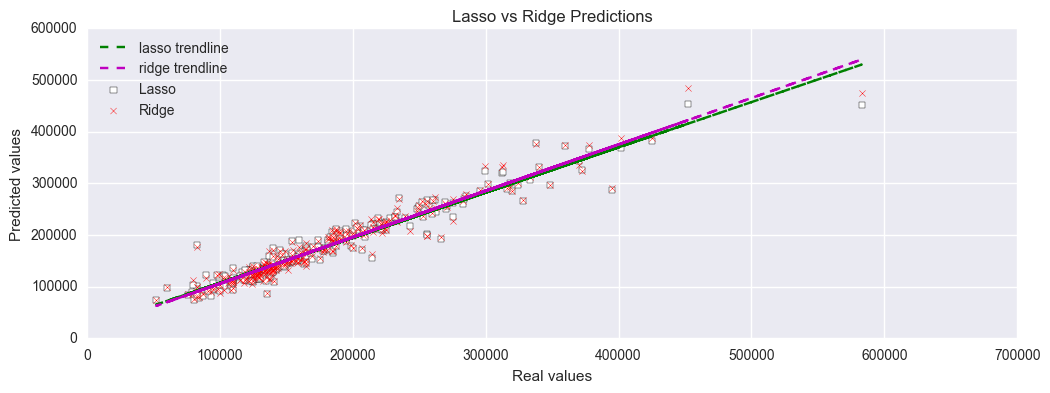

In [81]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test[features])), c = "white", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[features])), c = "red", marker = "x", label = "Ridge")
# calc the trendline
x = np.expm1(y_test.values)[:,0]
z = np.polyfit(x, np.expm1(lasso.predict(X_test[features])), 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--", label="lasso trendline")
z = np.polyfit(x, np.expm1(ridge.predict(X_test[features])[:,0]), 1)
r = np.poly1d(z)
plt.plot(x,r(x),"m--", label="ridge trendline")

plt.title("Lasso vs Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Looking at above, we can see that both Lasso and Ridge are predicting similar values. Also, the slope of both the trendlines are less than 1 so we are overall predicting lower values than actual. 

### Lets create polynomial features and run regression

In [82]:
poly_2_features = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscFeature_Shed"]
train[poly_2_features].head(2)

MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  2ndFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.751101   
1    0.000000    6.886532         0.0   5.652489     7.141245  0.000000   

   LowQualFinSF  WoodDeckSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0           0.0    0.000000            0.0        0.0          0.0   
1           0.0    5.700444            0.0        0.0          0.0   

   MiscFeature_Shed  
0               0.0  
1               0.0

In [83]:
cols2drop = train.filter(regex='\*2').columns.values
train.drop(cols2drop, axis=1, inplace=True)

In [85]:
train.shape

(1434, 299)

In [86]:
for col in poly_2_features:
    train[str(col) + "**2"] = train[col]**2

In [87]:
train.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

In [88]:
train.shape

(1434, 311)

**Lets save this data set**

In [89]:
train.to_csv("./train_engineered2_poly.csv")

In [90]:
output.to_csv("./output_engineered2_poly.csv")

In [91]:
train.shape, output.shape

((1434, 311), (1434, 1))

### Ridge Regression on Polynomial features

In [92]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=27)

In [93]:
ridge2 = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)

In [94]:
features = X_train.columns

In [95]:
features

Index([u'LotFrontage', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF',
       ...
       u'BsmtFinSF2**2', u'BsmtUnfSF**2', u'TotalBsmtSF**2', u'2ndFlrSF**2',
       u'LowQualFinSF**2', u'WoodDeckSF**2', u'EnclosedPorch**2',
       u'3SsnPorch**2', u'ScreenPorch**2', u'MiscFeature_Shed**2'],
      dtype='object', length=311)


Model Report
Training R-Square: 0.949
Training RMSE : 0.086
Validation R-Square: 0.916
Validation RMSE : 0.109
Variance score: 0.92
Optimal Alpha: 8.0947
Training cv_score (R^2 and MSE):  
[ 0.90583621  0.93162458  0.91501016  0.93579687  0.91639202]
[-0.01115934 -0.00942432 -0.01318788 -0.01059308 -0.01208471]
CV Score (R^2) : Mean: 0.920932 | Std: 0.01112527 | Min: 0.9058362 | Max: 0.9357969
CV Score (MSE) : Mean: -0.01128987 | Std: 0.001281954 | Min: -0.01318788 | Max: -0.009424321


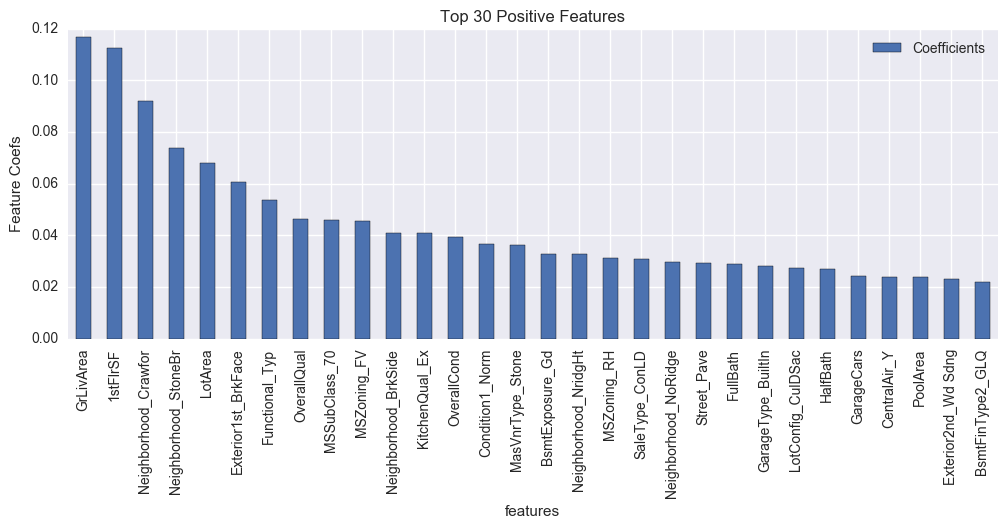

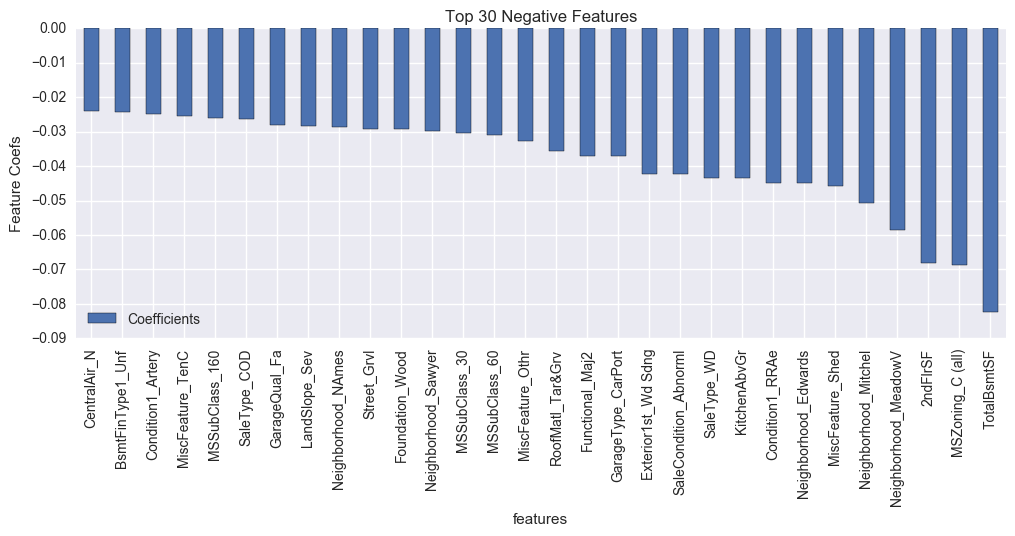

In [96]:
modelfit(ridge2, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=True)

In [97]:
# The coefficients
pd.set_option('display.max_rows', 500)
df = {'features': features, 'Coefficients': ridge2.coef_[0]}
ridge2_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
ridge2_coefficients

Coefficients               features
14       0.116660              GrLivArea
11       0.112603               1stFlrSF
84       0.091948   Neighborhood_Crawfor
100      0.073697   Neighborhood_StoneBr
1        0.068218                LotArea
150      0.060655    Exterior1st_BrkFace
249      0.053588         Functional_Typ
2        0.046546            OverallQual
43       0.046154          MSSubClass_70
54       0.045457            MSZoning_FV
81       0.041116   Neighborhood_BrkSide
239      0.041039         KitchenQual_Ex
3        0.039462            OverallCond
105      0.036727        Condition1_Norm
181      0.036226       MasVnrType_Stone
206      0.032922        BsmtExposure_Gd
94       0.032824   Neighborhood_NridgHt
55       0.031376            MSZoning_RH
287      0.030992         SaleType_ConLD
93       0.029808   Neighborhood_NoRidge
59       0.029197            Street_Pave
17       0.029139               FullBath
258      0.028340     GarageType_BuiltIn
71       0.027441      LotConfig_CulDSac
18       0.027078               HalfBath
23       0.024499             GarageCars
233      0.024034           CentralAir_Y
30       0.023989               PoolArea
176      0.023186    Exterior2nd_Wd Sdng
217      0.021993       BsmtFinType2_GLQ
61       0.021984             Alley_Pave
266      0.021863          GarageQual_Gd
107      0.021856        Condition1_PosN
120      0.021582          BldgType_1Fam
279      0.021302              PoolQC_Gd
246      0.020755        Functional_Min2
297      0.020370   SaleCondition_Normal
99       0.020296   Neighborhood_Somerst
182      0.019399           ExterQual_Ex
194      0.018850        Foundation_Slab
67       0.018562        LandContour_HLS
164      0.018433    Exterior2nd_Brk Cmn
141      0.018431       RoofMatl_Membran
48       0.018244         MSSubClass_120
115      0.017830        Condition2_PosA
215      0.017385       BsmtFinType2_ALQ
193      0.017168       Foundation_PConc
197      0.016658            BsmtQual_Ex
187      0.016569           ExterCond_Fa
256      0.016276      GarageType_Attchd
303      0.016255         TotalBsmtSF**2
254      0.016170         FireplaceQu_TA
138      0.015925         RoofStyle_Shed
290      0.015810           SaleType_New
41       0.015412          MSSubClass_50
179      0.015227     MasVnrType_BrkFace
250      0.014918         FireplaceQu_Ex
56       0.014886            MSZoning_RL
22       0.014736             Fireplaces
80       0.014335    Neighborhood_BrDale
76       0.014174          LandSlope_Mod
75       0.014112          LandSlope_Gtl
252      0.013866         FireplaceQu_Gd
264      0.013799          GarageQual_Ex
269      0.013799          GarageCond_Ex
15       0.013702           BsmtFullBath
294      0.013666  SaleCondition_AdjLand
285      0.013502           SaleType_CWD
186      0.013227           ExterCond_Ex
304      0.013196            2ndFlrSF**2
145      0.012974       RoofMatl_WdShake
211      0.012802       BsmtFinType1_GLQ
158      0.012647     Exterior1st_Stucco
126      0.011851      HouseStyle_1.5Unf
132      0.011814        HouseStyle_SLvl
111      0.011712        Condition1_RRNn
276      0.011610           PavedDrive_Y
114      0.011408        Condition2_Norm
227      0.010926           HeatingQC_Ex
37       0.010892          MSSubClass_20
288      0.010473         SaleType_ConLI
167      0.010083    Exterior2nd_CmentBd
146      0.009289       RoofMatl_WdShngl
209      0.009252       BsmtFinType1_ALQ
149      0.009134    Exterior1st_BrkComm
102      0.008913   Neighborhood_Veenker
222      0.008685           Heating_GasA
21       0.008487           TotRmsAbvGrd
51       0.008328         MSSubClass_180
0        0.008002            LotFrontage
226      0.007707           Heating_Wall
63       0.007494           LotShape_IR2
27       0.007379          EnclosedPorch
310      0.006865    MiscFeature_Shed**2
70       0.006612       LotConfig_Corner
157      0.006593      Exterior1st_Stone
96       0.006589     Neighb

In [102]:
X_test.shape

(287, 311)

In [106]:
train.filter(regex='\*2').columns.values

array(['MasVnrArea**2', 'BsmtFinSF1**2', 'BsmtFinSF2**2', 'BsmtUnfSF**2',
       'TotalBsmtSF**2', '2ndFlrSF**2', 'LowQualFinSF**2', 'WoodDeckSF**2',
       'EnclosedPorch**2', '3SsnPorch**2', 'ScreenPorch**2',
       'MiscFeature_Shed**2'], dtype=object)

In [112]:
non_poly_features = [x for x in X_train.columns if x not in X_train.filter(regex='\*2').columns.values]

In [114]:
X_test[non_poly_features].shape

(287, 299)

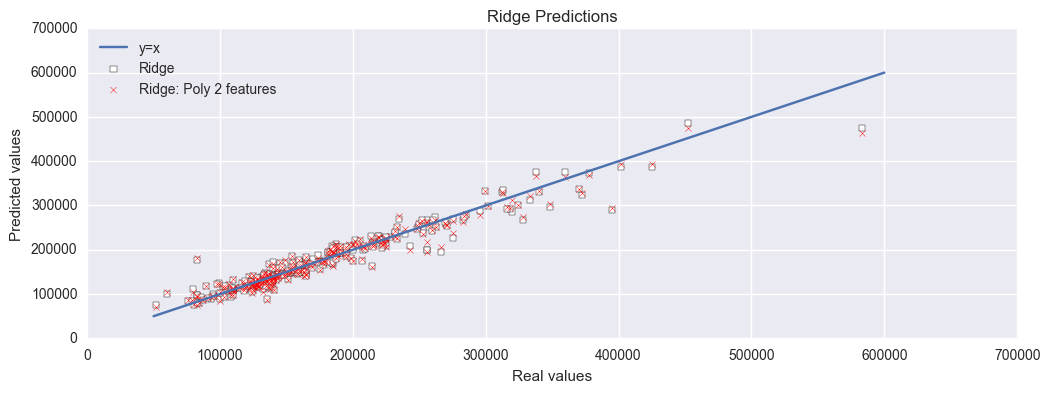

In [124]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(ridge.predict(X_test[non_poly_features])), c = "white", marker = "s", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test[features])), c = "red", marker = "x", label = "Ridge: Poly 2 features")
plt.plot([50000, 600000], [50000, 600000], label="y=x")

plt.title("Ridge Predictions")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

**Looking at above, ridge regression with some polynomial features perhaps does slightly better but the improvement is very small. Also, at larger values of output, errors are larger which is a concern!**

**Lets plot predictions against real values for some of the features**

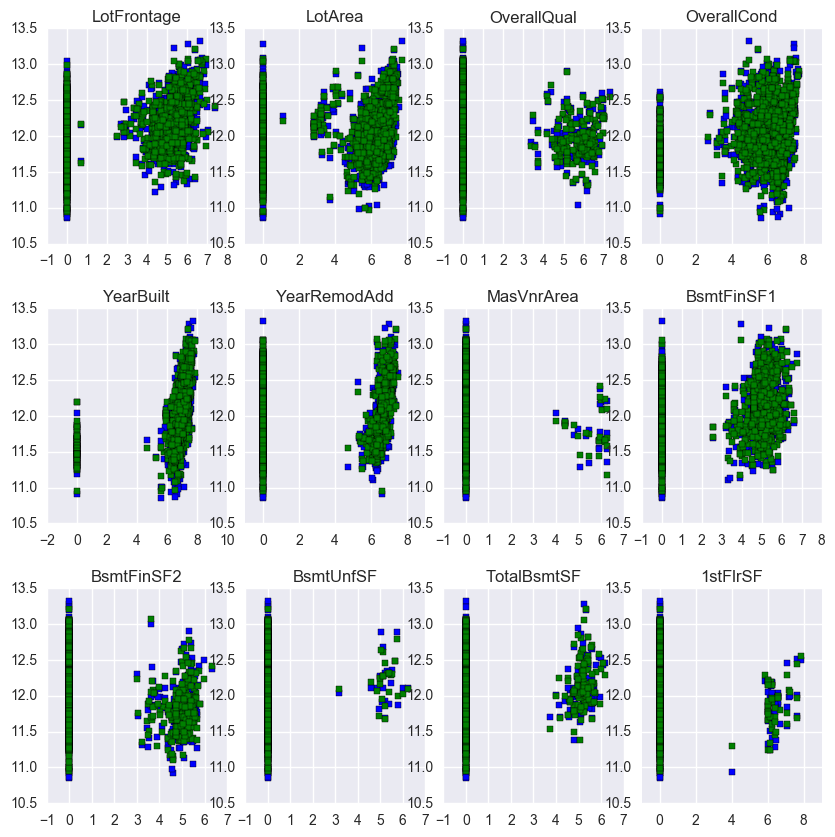

In [125]:
fig, axs = plt.subplots(3, 4, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)

axs = axs.ravel()

for i in range(len(poly_2_features)):
    axs[i].scatter(train[poly_2_features[i]].values, output.values, c = "blue", marker = "s")
    axs[i].scatter(train[poly_2_features[i]].values, ridge2.predict(train), c = "green", marker = "s")
    axs[i].set_title(train.columns[i])

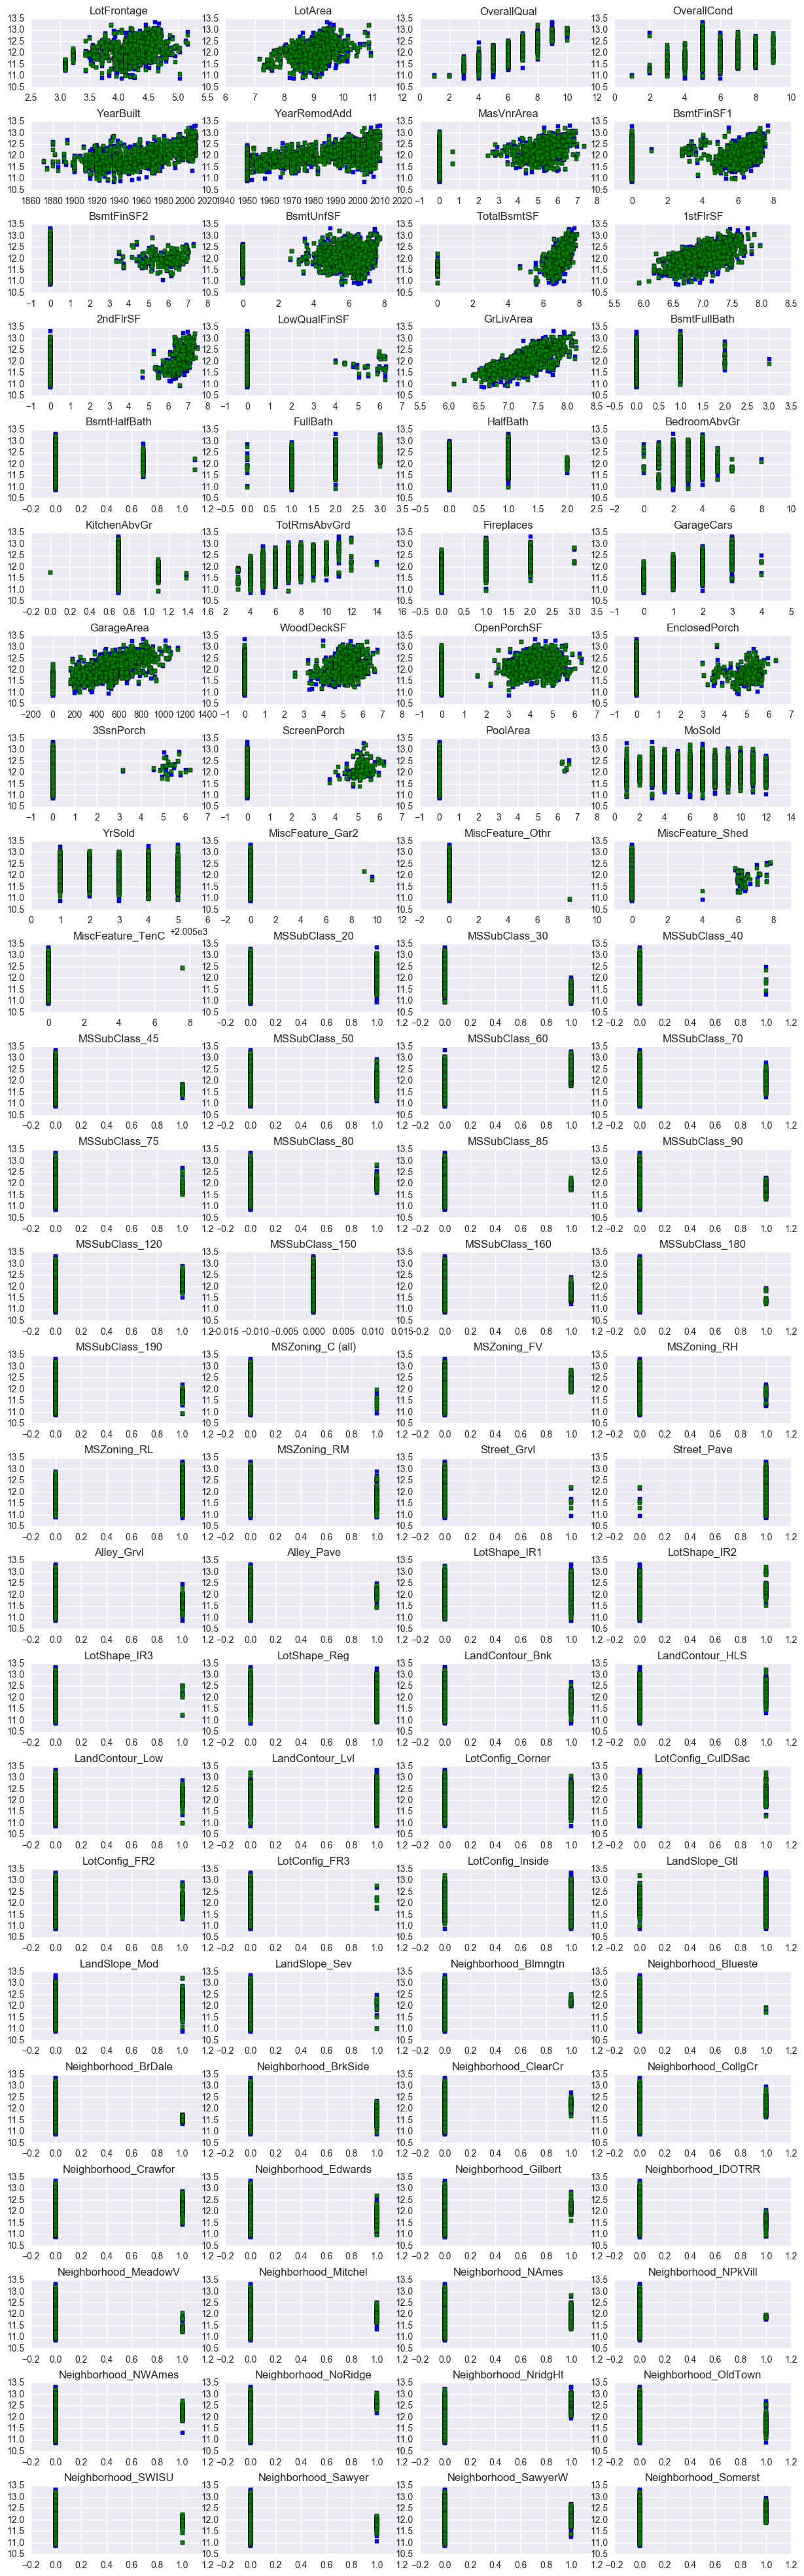

In [126]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(train[train.columns[i]].values, output.values, c = "blue", marker = "s")
    axs[i].scatter(train[train.columns[i]].values, ridge2.predict(train), c = "green", marker = "s")
    axs[i].set_title(train.columns[i])


### Lets try Lasso with polynomial features

In [127]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)
alpha

array([  1.98775873e+00,   5.78417078e+00,   5.38818543e-05,
         1.45424427e-01,   1.94067477e-02,   1.43483507e-03,
         1.04372769e-04,   7.44646580e-01,   2.51878485e-04,
         3.52170521e-01,   1.15809215e-02,   2.14706422e-03,
         7.61850040e-05,   8.27915132e-02,   6.57506563e-04,
         2.66956432e+00,   7.10100293e+00,   6.22564533e-06,
         3.52320899e-06,   5.39431980e-03,   6.70439000e-03,
         1.89089291e-04,   7.77434670e-02,   1.58005679e+00,
         2.23165310e-02,   3.08854927e-01,   1.26884658e-05,
         2.02672220e-02,   2.58059002e-04,   1.28576104e-03,
         4.62825007e-05,   9.20926153e+00,   6.60182084e-01,
         4.14456724e-03,   7.02961497e-05,   6.21035689e+00,
         2.29960043e-05,   2.62915190e+00,   3.51662749e-03,
         5.52862621e-05,   2.85009372e-06,   9.98592200e-06,
         1.85099903e+00,   5.82476401e-05,   3.88339732e-06,
         3.22178000e-06,   8.01461661e-01,   4.76329553e-03,
         2.59161881e-03,

In [128]:
lasso2 = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [129]:
modelfit(lasso2, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)


Model Report
Training R-Square: 0.941
Training RMSE : 0.093
Validation R-Square: 0.914
Validation RMSE : 0.111
Variance score: 0.91
Optimal Alpha: 0.0007
Training cv_score (R^2 and MSE):  
[ 0.90294779  0.93437058  0.92273577  0.93594022  0.91764193]
[-0.01150165 -0.00904583 -0.0119891  -0.01056943 -0.01190405]
CV Score (R^2) : Mean: 0.9227273 | Std: 0.01206016 | Min: 0.9029478 | Max: 0.9359402
CV Score (MSE) : Mean: -0.01100201 | Std: 0.001100127 | Min: -0.0119891 | Max: -0.009045835


In [131]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso2.coef_}
lasso_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients

Coefficients               features
14   2.041851e-01              GrLivArea
84   1.137775e-01   Neighborhood_Crawfor
11   9.794078e-02               1stFlrSF
150  7.655031e-02    Exterior1st_BrkFace
100  7.434524e-02   Neighborhood_StoneBr
1    6.356743e-02                LotArea
249  5.883343e-02         Functional_Typ
2    5.462291e-02            OverallQual
239  5.415322e-02         KitchenQual_Ex
81   4.803350e-02   Neighborhood_BrkSide
3    4.325501e-02            OverallCond
206  4.138942e-02        BsmtExposure_Gd
54   3.810457e-02            MSZoning_FV
105  3.614804e-02        Condition1_Norm
197  3.350917e-02            BsmtQual_Ex
120  3.260757e-02          BldgType_1Fam
94   2.897594e-02   Neighborhood_NridgHt
43   2.636717e-02          MSSubClass_70
22   2.053837e-02             Fireplaces
193  1.910764e-02       Foundation_PConc
227  1.855562e-02           HeatingQC_Ex
303  1.676763e-02         TotalBsmtSF**2
17   1.671948e-02               FullBath
23   1.638356e-02             GarageCars
71   1.544930e-02      LotConfig_CulDSac
182  1.543771e-02           ExterQual_Ex
93   1.435684e-02   Neighborhood_NoRidge
258  1.337570e-02     GarageType_BuiltIn
30   1.307054e-02               PoolArea
15   1.287381e-02           BsmtFullBath
48   1.287315e-02         MSSubClass_120
181  1.230239e-02       MasVnrType_Stone
18   1.185106e-02               HalfBath
99   9.849842e-03   Neighborhood_Somerst
261  8.833695e-03       GarageFinish_Fin
304  8.336236e-03            2ndFlrSF**2
256  6.351367e-03      GarageType_Attchd
21   5.627863e-03           TotRmsAbvGrd
276  5.417952e-03           PavedDrive_Y
67   5.387580e-03        LandContour_HLS
252  4.181349e-03         FireplaceQu_Gd
299  2.790290e-03          MasVnrArea**2
26   2.788648e-03            OpenPorchSF
310  2.486618e-03    MiscFeature_Shed**2
4    2.221421e-03              YearBuilt
155  2.013290e-03    Exterior1st_MetalSd
306  1.845667e-03          WoodDeckSF**2
300  1.454752e-03          BsmtFinSF1**2
309  1.326219e-03         ScreenPorch**2
136  9.579992e-04          RoofStyle_Hip
5    8.712060e-04           YearRemodAdd
307  7.818544e-04       EnclosedPorch**2
308  6.128207e-04           3SsnPorch**2
290  5.326578e-04           SaleType_New
301  4.998481e-04          BsmtFinSF2**2
24   1.286384e-04             GarageArea
233  1.735575e-18           CentralAir_Y
218 -0.000000e+00       BsmtFinType2_LwQ
207  0.000000e+00        BsmtExposure_Mn
209  0.000000e+00       BsmtFinType1_ALQ
210  0.000000e+00       BsmtFinType1_BLQ
211  0.000000e+00       BsmtFinType1_GLQ
212 -0.000000e+00       BsmtFinType1_LwQ
205 -0.000000e+00        BsmtExposure_Av
214 -0.000000e+00       BsmtFinType1_Unf
215  0.000000e+00       BsmtFinType2_ALQ
216 -0.000000e+00       BsmtFinType2_BLQ
217  0.000000e+00       BsmtFinType2_GLQ
222  0.000000e+00           Heating_GasA
219 -0.000000e+00       BsmtFinType2_Rec
220  0.000000e+00       BsmtFinType2_Unf
221 -0.000000e+00          Heating_Floor
203 -0.000000e+00            BsmtCond_Po
223 -0.000000e+00           Heating_GasW
224 -0.000000e+00           Heating_Grav
225 -0.000000e+00           Heating_OthW
226  0.000000e+00           Heating_Wall
20  -0.000000e+00           KitchenAbvGr
228 -0.000000e+00           HeatingQC_Fa
229  0.000000e+00           HeatingQC_Gd
230 -0.000000e+00           HeatingQC_Po
204  0.000000e+00            BsmtCond_TA
46  -0.000000e+00          MSSubClass_85
202 -0.000000e+00            BsmtCond_Gd
201 -0.000000e+00            BsmtCond_Fa
170  0.000000e+00    Exterior2nd_MetalSd
171 -0.000000e+00      Exterior2nd_Other
173 -0.000000e+00      Exterior2nd_Stone
174  0.000000e+00     Exterior2nd_Stucco
175  0.000000e+00    Exterior2nd_VinylSd
176  0.000000e+00    Exterior2nd_Wd Sdng
177 -0.000000e+00    Exterior2nd_Wd Shng
179 -0.000000e+00     MasVnrType_BrkFace
180  0.000000e+00        MasVnrType_None
29  -0.000000e+00            ScreenPorch
28   0.000000e+00              3SsnPorch
183 -0.000000e+00           

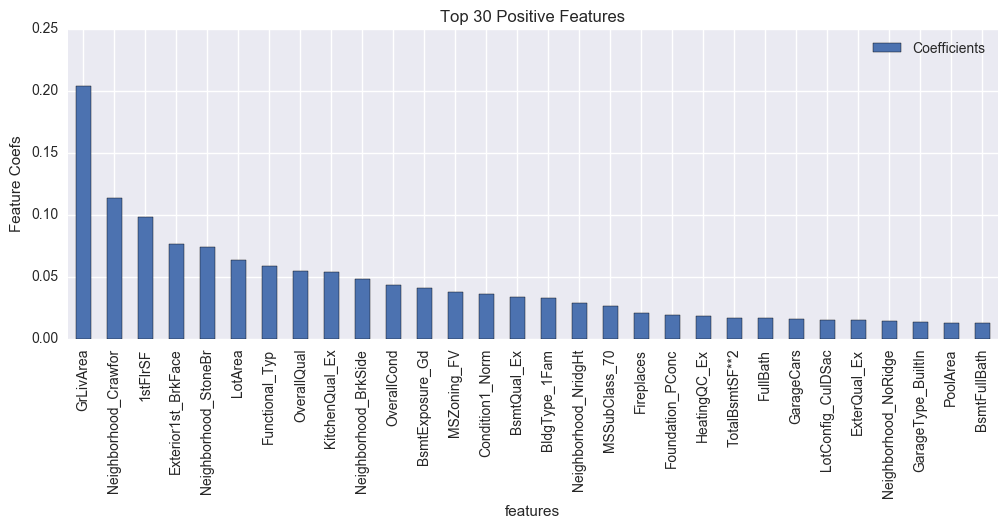

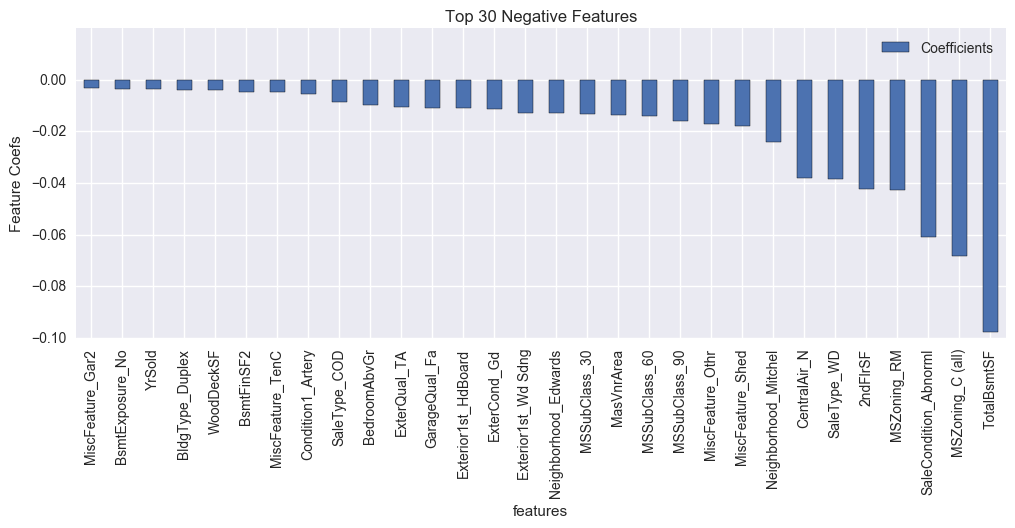

In [132]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

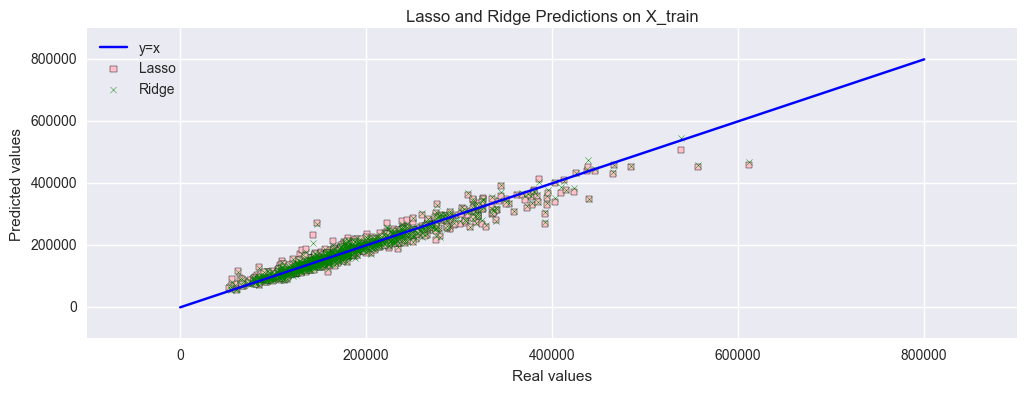

In [136]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_train.values), np.expm1(lasso2.predict(X_train)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_train.values), np.expm1(ridge2.predict(X_train)), c = "green", marker = "x", label = "Ridge")
plt.plot([0,800000],[0,800000], c="blue", label="y=x" )
plt.title("Lasso and Ridge Predictions on X_train")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

Even for training data, errors increase for larger values of output.

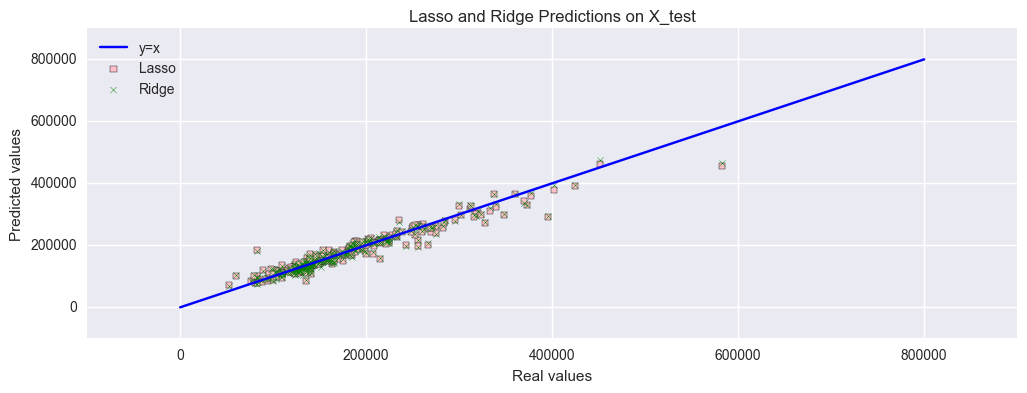

In [137]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso2.predict(X_test)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "x", label = "Ridge")
plt.plot([0,800000],[0,800000], c="blue", label="y=x" )
plt.title("Lasso and Ridge Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

## Gradient Boosting

Reference: https://github.com/ptiwaree/Kaggle-HousePrices/blob/master/House%20Prices%20-%20Boosting-2.ipynb

Optimal parameters used come from using gridsearch in the above notebook.

In [429]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions

In [430]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

In [431]:
min_samples_split = 0.001
min_samples_leaf = 27 
max_depth = 3
max_features = 22
subsample = 0.8
n_estimators=30000
learning_rate=0.0015


Model Report
R-Square: 0.970
RMSE : 0.066
cv_score: 
[ 0.90388086  0.92848105  0.91671466  0.93244944  0.90901828]
CV Score : Mean: 0.9181089 | Std: 0.01095676 | Min: 0.9038809 | Max: 0.9324494


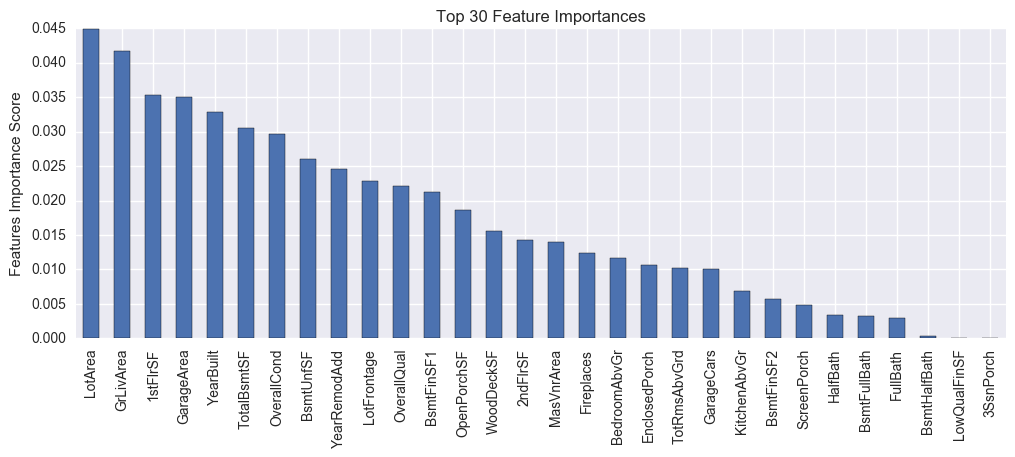

In [432]:
gbm = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm, X_train, features, y_train.values)

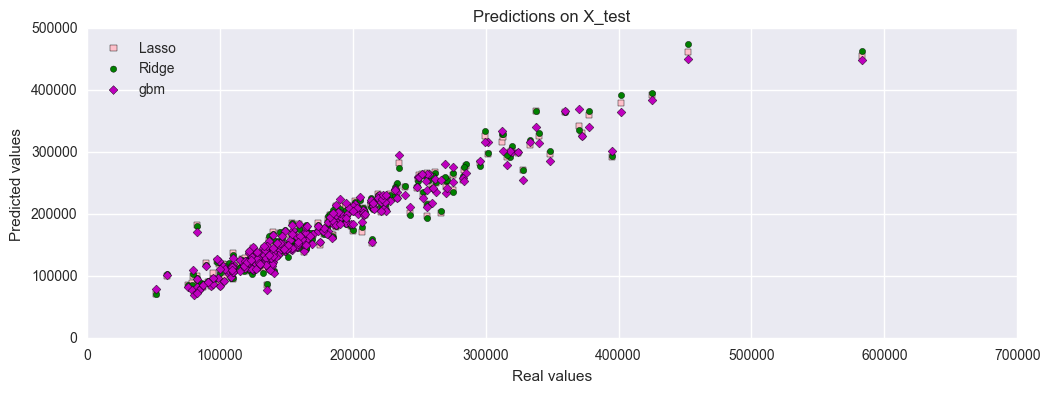

In [433]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "o", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "m", marker = "D", label = "gbm")

plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

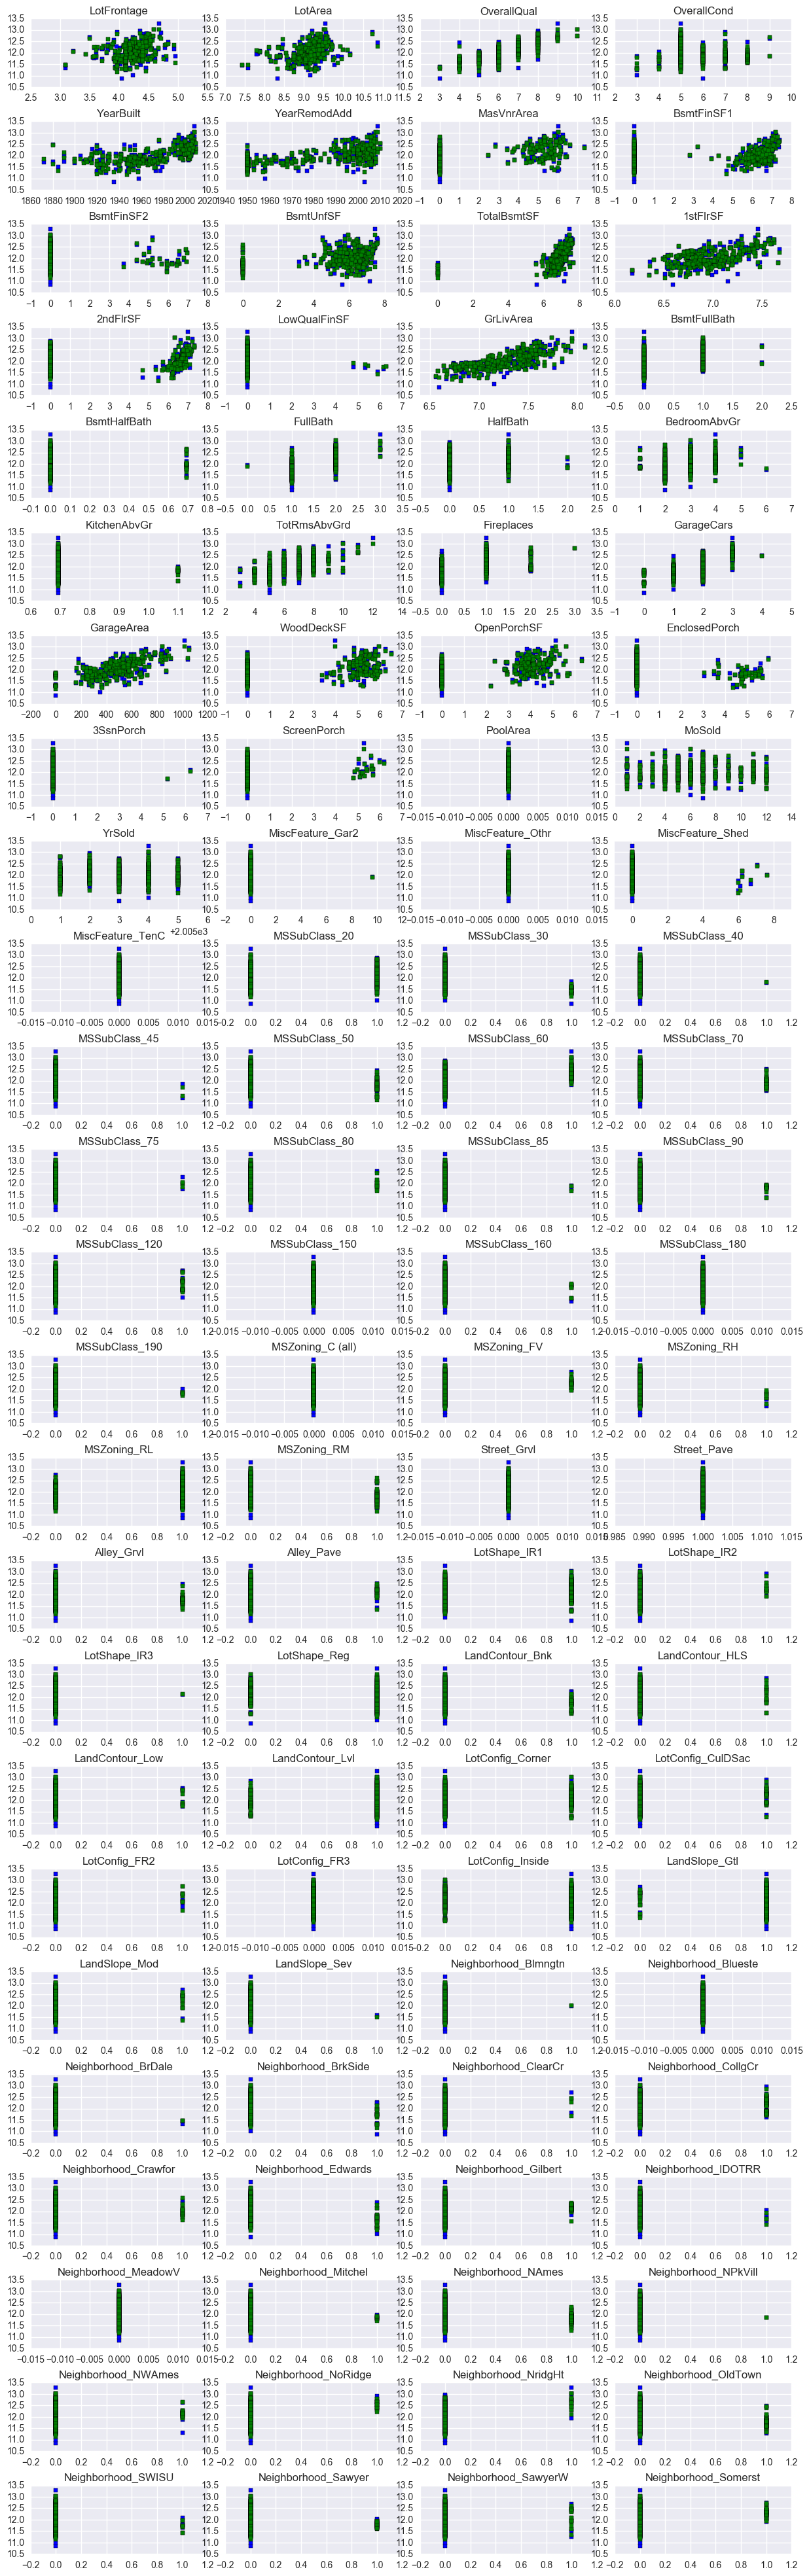

In [434]:
fig, axs = plt.subplots(25, 4, figsize=(15, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(100):
    axs[i].scatter(X_test[X_test.columns[i]].values, y_test.values, c = "blue", marker = "s")
    axs[i].scatter(X_test[X_test.columns[i]].values, gbm.predict(X_test), c = "green", marker = "s")
    axs[i].set_title(train.columns[i])

### Lets take a median of the neighborhood and see how well it makes predictions

In [435]:
X_train.head(3)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
939      4.400603  10.089594            7            7       1940   
1430     4.110874   9.995656            5            5       2005   
40       4.442651   9.066355            6            5       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
939           1950    0.000000    0.000000         0.0   6.940222   
1430          2005    0.000000    0.000000         0.0   6.597146   
40            1965    4.624973    6.467699         0.0   6.100319   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
939      6.940222  7.096721  7.087574           0.0   7.784889           0.0   
1430     6.597146  6.599870  7.007601           0.0   7.516977           0.0   
40       6.993015  7.189168  0.000000           0.0   7.189168           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
939            0.0         2         0             4      0.693147   
1430           0.0         2         1             4      0.693147   
40             0.0         2         0             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
939             10           2         1.0       349.0    4.043051   
1430             7           1         2.0       372.0    4.615121   
40               6           1         2.0       440.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
939      0.000000       5.765191        0.0          0.0       0.0       6   
1430     3.713572       0.000000        0.0          0.0       0.0       7   
40       4.934474       0.000000        0.0          0.0       0.0      12   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
939     2010               0.0               0.0               0.0   
1430    2006               0.0               0.0               0.0   
40      2006               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
939                0.0              0              0              0   
1430               0.0              0              0              0   
40                 0.0              1              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
939               0              0              0              1   
1430              0              0              1              0   
40                0              0              0              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
939               0              0              0              0   
1430              0              0              0              0   
40                0              0              0              0   

      MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_180  \
939                0               0               0               0   
1430               0               0               0               0   
40                 0               0               0               0   

      MSSubClass_190  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
939                0                 0            0            0            1   
1430               0                 0            0            0            1   
40                 0                 0            0            0            1   

      MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  \
939             0            0            1           0           0   
1430            0            0            1           0           0   
40              0            0            1           0           0   

      LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  \
939              0             0             0             1                0   
1430             0             0             1             0                0   
40

In [436]:
X_train.shape, y_train.shape

((1147, 311), (1147, 1))

In [437]:
df = pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index])

In [438]:
df.shape

(1147, 312)

In [439]:
df.head(5)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
939      4.400603  10.089594            7            7       1940   
1430     4.110874   9.995656            5            5       2005   
40       4.442651   9.066355            6            5       1965   
952      4.110874   8.881975            5            8       1972   
1265     3.583519   8.225771            7            5       1999   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
939           1950    0.000000    0.000000         0.0   6.940222   
1430          2005    0.000000    0.000000         0.0   6.597146   
40            1965    4.624973    6.467699         0.0   6.100319   
952           2003    0.000000    6.493754         0.0   4.691348   
1265          1999    5.389072    6.111467         0.0   5.488938   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
939      6.940222  7.096721  7.087574           0.0   7.784889           0.0   
1430     6.597146  6.599870  7.007601           0.0   7.516977           0.0   
40       6.993015  7.189168  0.000000           0.0   7.189168           0.0   
952      6.645091  6.645091  0.000000           0.0   6.645091           0.0   
1265     6.539586  6.570883  6.606650           0.0   7.281386           1.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
939       0.000000         2         0             4      0.693147   
1430      0.000000         2         1             4      0.693147   
40        0.000000         2         0             3      0.693147   
952       0.693147         1         0             2      0.693147   
1265      0.000000         2         1             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
939             10           2         1.0       349.0    4.043051   
1430             7           1         2.0       372.0    4.615121   
40               6           1         2.0       440.0    0.000000   
952              5           0         1.0       396.0    5.262690   
1265             6           0         2.0       506.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
939      0.000000       5.765191        0.0          0.0       0.0       6   
1430     3.713572       0.000000        0.0          0.0       0.0       7   
40       4.934474       0.000000        0.0          0.0       0.0      12   
952      0.000000       0.000000        0.0          0.0       0.0       4   
1265     3.555348       0.000000        0.0          0.0       0.0       3   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
939     2010               0.0               0.0               0.0   
1430    2006               0.0               0.0               0.0   
40      2006               0.0               0.0               0.0   
952     2009               0.0               0.0               0.0   
1265    2006               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
939                0.0              0              0              0   
1430               0.0              0              0              0   
40                 0.0              1              0              0   
952                0.0              0              0              0   
1265               0.0              0              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
939               0              0              0              1   
1430              0              0              1              0   
40                0              0              0              0   
952               0              0              0              0   
1265              0              0              0              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
939               0              0              0          

In [440]:
df['Neighborhood'] = df[df.filter(regex='Neighborhood').columns.values].idxmax(1) #reverse one hot encoding

In [441]:
neighborhood_median_price = df.groupby(['Neighborhood'])['log_SalePrice'].median()

In [442]:
neighborhood_median_price

Neighborhood
Neighborhood_Blmngtn    12.162645
Neighborhood_Blueste    11.826543
Neighborhood_BrDale     11.598733
Neighborhood_BrkSide    11.706027
Neighborhood_ClearCr    12.160020
Neighborhood_CollgCr    12.206430
Neighborhood_Crawfor    12.300250
Neighborhood_Edwards    11.736077
Neighborhood_Gilbert    12.099786
Neighborhood_IDOTRR     11.575910
Neighborhood_MeadowV    11.385103
Neighborhood_Mitchel    11.957618
Neighborhood_NAmes      11.860056
Neighborhood_NPkVill    11.894782
Neighborhood_NWAmes     12.106258
Neighborhood_NoRidge    12.577640
Neighborhood_NridgHt    12.659737
Neighborhood_OldTown    11.669510
Neighborhood_SWISU      11.849405
Neighborhood_Sawyer     11.813037
Neighborhood_SawyerW    12.100440
Neighborhood_Somerst    12.329841
Neighborhood_StoneBr    12.529955
Neighborhood_Timber     12.360664
Neighborhood_Veenker    12.351656
Name: log_SalePrice, dtype: float64

In [443]:
X_test_median_pred = neighborhood_median_price[X_test[X_test.filter(regex='Neighborhood').columns.values].idxmax(1)] #reverse one hot encoding

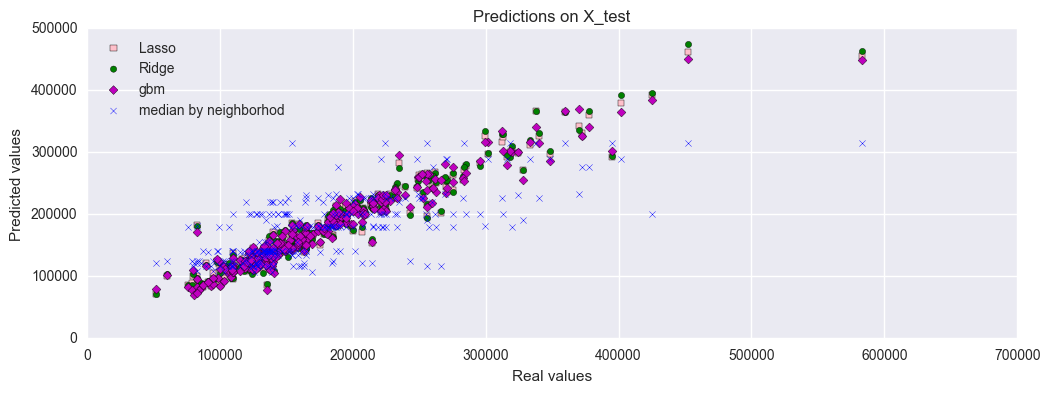

In [444]:
# Plot Predictions vs Actual Output
plt.scatter(np.expm1(y_test.values), np.expm1(lasso.predict(X_test)), c = "pink", marker = "s", label = "Lasso")
plt.scatter(np.expm1(y_test.values), np.expm1(ridge2.predict(X_test)), c = "green", marker = "o", label = "Ridge")
plt.scatter(np.expm1(y_test.values), np.expm1(gbm.predict(X_test)), c = "m", marker = "D", label = "gbm")
plt.scatter(np.expm1(y_test.values), np.expm1(X_test_median_pred), c = "blue", marker = "x", label = "median by neighborhod")

plt.title("Predictions on X_test")
plt.ylabel("Predicted values")
plt.xlabel("Real values")
plt.legend(loc = "upper left")
plt.show()

In [445]:
y_test[y_test.log_SalePrice>13].index

Int64Index([591, 803], dtype='int64')

In [446]:
X_test.loc[[591, 803],:]

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
591     4.584967  9.508888           10            5       2008          2008   
803     4.682131  9.539068            9            5       2008          2009   

     MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
591    6.042633    7.199678         0.0   5.953243     7.451822  7.455298   
803    6.052089    0.000000         0.0   7.458763     7.458763  7.458763   

     2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
591  6.343880           0.0   7.739359           1.0           0.0         2   
803  6.993015           0.0   7.945555           0.0           0.0         3   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
591         1             3      0.693147            10           1   
803         1             4      0.693147            12           1   

     GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
591         3.0       842.0    5.948035     5.616771            0.0   
803         3.0      1020.0    3.970292     5.141664            0.0   

     3SsnPorch  ScreenPorch  PoolArea  MoSold  YrSold  MiscFeature_Gar2  \
591        0.0      0.00000       0.0       6    2009               0.0   
803        0.0      5.26269       0.0       1    2009               0.0   

     MiscFeature_Othr  MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  \
591               0.0               0.0               0.0              0   
803               0.0               0.0               0.0              0   

     MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  \
591              0              0              0              0   
803              0              0              0              0   

     MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
591              1              0              0              0   
803              1              0              0              0   

     MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_150  \
591              0              0               0               0   
803              0              0               0               0   

     MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_C (all)  \
591               0               0               0                 0   
803               0               0               0                 0   

     MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  \
591            0            0            1            0            0   
803            0            0            1            0            0   

     Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  LotShape_IR2  \
591            1           0           0             1             0   
803            1           0           0             0             0   

     LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
591             0             0                0                0   
803             0             1                0                0   

     LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
591                0                1                 1                  0   
803                0                1                 0                  0   

     LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
591              0              0                 0              1   
803              0              0                 1              1   

     LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
591              0              0                     0                     0   
803              0              0                     0                     0   

     Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
591                    0                     0                     0   
803                    0                     0                     0   

     Neighborhood_CollgC

### Lets make some predictions before we do stacking

In [447]:
house_prices_test = pd.read_csv('test.csv')
house_prices_test.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       1961.0          Unf         1.0       730.0         TA   
1     Attchd       1958.0          Unf         1.0       312.0         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y         140            0              0          0   
1         TA          Y         393           36              0          0   

   ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold  \
0          120         0    NaN  MnPrv         NaN        0       6    2010   
1            0         0    NaN    NaN        Gar2    12500       6    2010   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal

In [448]:
house_prices_test.shape, test.shape, train.shape

((1459, 80), (1459, 299), (1434, 311))

In [449]:
for col in poly_2_features:
    test[str(col) + "**2"] = test[col]**2

In [450]:
house_prices_test.shape, test.shape, train.shape

((1459, 80), (1459, 311), (1434, 311))

In [451]:
house_prices_test['Id'].values

array([1461, 1462, 1463, ..., 2917, 2918, 2919])

In [452]:
pred1 = np.expm1(ridge2.predict(test)[:,0]/3.0 + lasso.predict(test)/3.0 + gbm.predict(test)/3.0)
#pred1
pred1 = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred1})
pred1.head(5)

Id      SalePrice
0  1461  125914.179861
1  1462  150699.164697
2  1463  187204.413580
3  1464  200191.944401
4  1465  192839.921041

In [453]:
np.expm1(ridge2.predict(test))[:,0]

array([ 124931.33932306,  140706.59349253,  187147.42413024, ...,
        172610.0015097 ,  117615.43178575,  220160.53770133])

In [454]:
#pred1.to_csv('kaggle_submission_lassoridgegbm_Jan272017.csv', index=False)

In [455]:
pred1 = np.expm1(lasso.predict(test) * 0.5 + gbm.predict(test) * 0.5)
#pred1
pred1 = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred1})
pred1.head(5)

Id      SalePrice
0  1461  126408.495835
1  1462  155958.495881
2  1463  187232.914812
3  1464  199099.434983
4  1465  192192.106892

In [456]:
#pred1.to_csv('kaggle_submission_lassogbm_Jan272017.csv', index=False)

kaggle_submission_lassoridgegbm_Jan272017.csv did better with LB score of 0.11995 which did not beat the best score of 0.11755 which uses gbm and lasso.

## Model Stacking (aka Meta Ensemble)

http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

### STEP 1:
#### Partition the training data into five test folds
#### Create a dataset called train_meta with the same row Ids and fold Ids as the training dataset, with empty columns M1 and M2. Similarly create a dataset called test_meta with the same row Ids as the test dataset and empty columns M1 and M2

In [457]:
#train_meta = train #this doesnt work. it creates a common pointer but we want a copy
train_meta = train.copy(deep=True)

In [458]:
train_meta.shape, train.shape

((1434, 311), (1434, 311))

In [459]:
train_meta['Ridge'] = np.nan
train_meta['Lasso'] = np.nan
train_meta['gbm'] = np.nan

In [460]:
train_meta.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   
2     4.234107  9.328212            7            5       2001          2002   
3     4.110874  9.164401            7            5       1915          1970   
4     4.442651  9.565284            8            5       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   
2    5.093750    6.188264         0.0   6.075346     6.825460  6.825460   
3    0.000000    5.379897         0.0   6.293419     6.629363  6.869014   
4    5.860786    6.486161         0.0   6.196444     7.044033  7.044033   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   
2  6.765039           0.0   7.488294           1.0      0.000000         2   
3  6.629363           0.0   7.448916           1.0      0.000000         1   
4  6.960348           0.0   7.695758           1.0      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   
2         1             3      0.693147             6           1         2.0   
3         0             3      0.693147             7           1         3.0   
4         1             4      0.693147             9           1         3.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134       0.000000        0.0          0.0   
1       460.0    5.700444     0.000000       0.000000        0.0          0.0   
2       608.0    0.000000     3.761200       0.000000        0.0          0.0   
3       642.0    0.000000     3.583519       5.609472        0.0          0.0   
4       836.0    5.262690     4.442651       0.000000        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   
2       0.0       9    2008               0.0               0.0   
3       0.0       2    2006               0.0               0.0   
4       0.0      12    2008               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   
2               0.0               0.0              0              0   
3               0.0               0.0              0              0   
4               0.0               0.0              0              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              1   
4              0              0              0              1              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              0              0              0              0               0   

In [461]:
train.shape, train_meta.shape

((1434, 311), (1434, 314))

In [462]:
test_meta = test.copy(deep=True)
test_meta['Ridge'] = np.nan
test_meta['Lasso'] = np.nan
test_meta['gbm'] = np.nan

In [463]:
test_meta.shape, test.shape

((1459, 314), (1459, 311))

In [464]:
train_meta.reset_index(drop=True, inplace=True)

In [465]:
output.reset_index(drop=True, inplace=True)

In [466]:
train_meta.head(2)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.189655  9.042040            7            5       2003          2003   
1     4.394449  9.169623            6            8       1976          1976   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    5.283204    6.561031         0.0   5.017280     6.753438  6.753438   
1    0.000000    6.886532         0.0   5.652489     7.141245  7.141245   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  6.751101           0.0   7.444833           1.0      0.000000         2   
1  0.000000           0.0   7.141245           0.0      0.693147         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3      0.693147             8           0         2.0   
1         0             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       548.0    0.000000     4.127134            0.0        0.0          0.0   
1       460.0    5.700444     0.000000            0.0        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       2    2008               0.0               0.0   
1       0.0       5    2007               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              1              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              0              1              0   
1              0              0              0              0              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   

   MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_Pave  LotShape_IR1  \
0            0            1           0           0             0   
1            0            1           0           0             0   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   

   LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
0                0                1                 0                  0   
1                0                1                 0                  0   

   LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
0              0              0                 1              1   
1              1              0                 0              1   

   LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0              0              0                     0                     0   
1              0              0                     0                     0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                    0                     0                     0   
1                    0                     0                     0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
0                     1                     0                     0   
1   

#### For assigning fold ID, not sure if this is the best way but first I shuffle the dataframe, then reset index, and then assign fold ID sequentially.

In [467]:
train_meta['fold_ID'] = np.nan

In [468]:
train_meta = train_meta.sample(frac=1, random_state=67, replace=False) #shuffle

In [469]:
output = output.sample(frac=1, random_state=67, replace=False)

In [470]:
output.head(5)

log_SalePrice
1161      11.560772
229       11.456366
60        11.522886
472       12.832014
1251      11.995358

In [471]:
train_meta.head(5)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1161     4.110874  9.183894            5            7       1924   
229      3.091042  7.427144            6            5       1972   
60       4.110874  8.881975            5            7       1920   
472      4.290459  9.379830            9            5       2003   
1251     4.394449  9.467847            6            6       1972   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
1161          1950    0.000000    5.973810         0.0   5.973810   
229           1972    5.697093    0.000000         0.0   6.182085   
60            1996    0.000000    0.000000         0.0   6.274762   
472           2004    6.333280    7.357556         0.0   5.420535   
1251          1972    0.000000    6.386879         0.0   4.875197   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
1161     6.665684  6.856462  5.609472           0.0   7.108244           1.0   
229      6.182085  6.182085  6.224558           0.0   6.895683           0.0   
60       6.274762  6.366470  6.274762           0.0   7.013915           0.0   
472      7.491645  7.491645  0.000000           0.0   7.491645           1.0   
1251     6.584791  6.601230  6.493754           0.0   7.241366           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1161      0.000000         1         0             4      0.693147   
229       0.000000         1         1             2      0.693147   
60        0.000000         1         0             3      0.693147   
472       0.000000         2         0             2      0.693147   
1251      0.693147         1         1             3      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
1161             7           0         1.0       392.0    0.000000   
229              5           1         1.0       288.0    0.000000   
60               6           0         1.0       288.0    0.000000   
472              6           1         3.0       874.0    5.332719   
1251             6           1         2.0       497.0    5.686975   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MoSold  \
1161     0.000000       5.468060        0.0          0.0       0.0       3   
229      0.000000       0.000000        0.0          0.0       0.0       6   
60       0.000000       4.976734        0.0          0.0       0.0       3   
472      3.912023       0.000000        0.0          0.0       0.0       8   
1251     4.762174       0.000000        0.0          0.0       0.0      12   

      YrSold  MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  \
1161    2006               0.0               0.0               0.0   
229     2006               0.0               0.0               0.0   
60      2007               0.0               0.0               0.0   
472     2006               0.0               0.0               0.0   
1251    2009               0.0               0.0               0.0   

      MiscFeature_TenC  MSSubClass_20  MSSubClass_30  MSSubClass_40  \
1161               0.0              0              0              0   
229                0.0              0              0              0   
60                 0.0              0              0              0   
472                0.0              1              0              0   
1251               0.0              0              0              0   

      MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
1161              0              1              0              0   
229               0              0              0              0   
60                0              0              0              0   
472               0              0              0              0   
1251              0              0              1              0   

      MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
1161              0              0              0              0 

In [472]:
train_meta.reset_index(drop=True, inplace=True)
output.reset_index(drop=True, inplace=True)

In [473]:
fold_ID = 0
for i in xrange(0, len(train_meta)):
    fold_ID = fold_ID + 1
    train_meta.loc[i, 'fold_ID'] = fold_ID
    if fold_ID%5==0:
        fold_ID=0

In [474]:
train_meta.head(10)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.110874  9.183894            5            7       1924          1950   
1     3.091042  7.427144            6            5       1972          1972   
2     4.110874  8.881975            5            7       1920          1996   
3     4.290459  9.379830            9            5       2003          2004   
4     4.394449  9.467847            6            6       1972          1972   
5     4.174387  9.290352            7            5       1994          1996   
6     4.219508  9.093919            4            4       1966          1966   
7     4.110874  8.857230            5            5       2005          2006   
8     4.488636  9.044522            6            7       1977          1995   
9     4.304065  9.069813            7            5       2005          2005   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.000000    5.973810         0.0   5.973810     6.665684  6.856462   
1    5.697093    0.000000         0.0   6.182085     6.182085  6.182085   
2    0.000000    0.000000         0.0   6.274762     6.274762  6.366470   
3    6.333280    7.357556         0.0   5.420535     7.491645  7.491645   
4    0.000000    6.386879         0.0   4.875197     6.584791  6.601230   
5    0.000000    0.000000         0.0   6.569481     6.569481  6.991177   
6    0.000000    6.963190         0.0   0.000000     6.963190  6.963190   
7    0.000000    6.888572         0.0   4.709530     6.994850  6.994850   
8    3.850148    6.228511         0.0   0.000000     6.228511  7.100852   
9    5.433722    0.000000         0.0   7.388328     7.388328  7.388328   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  5.609472           0.0   7.108244           1.0      0.000000         1   
1  6.224558           0.0   6.895683           0.0      0.000000         1   
2  6.274762           0.0   7.013915           0.0      0.000000         1   
3  0.000000           0.0   7.491645           1.0      0.000000         2   
4  6.493754           0.0   7.241366           0.0      0.693147         1   
5  6.697034           0.0   7.547502           0.0      0.000000         2   
6  0.000000           0.0   6.963190           1.0      0.000000         1   
7  0.000000           0.0   6.994850           1.0      0.000000         1   
8  0.000000           0.0   7.100852           1.0      0.000000         1   
9  0.000000           0.0   7.388328           0.0      0.000000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         0             4      0.693147             7           0         1.0   
1         1             2      0.693147             5           1         1.0   
2         0             3      0.693147             6           0         1.0   
3         0             2      0.693147             6           1         3.0   
4         1             3      0.693147             6           1         2.0   
5         1             3      0.693147             7           1         2.0   
6         0             2      0.693147             5           0         1.0   
7         1             2      0.693147             5           0         2.0   
8         0             3      0.693147             6           1         2.0   
9         0             3      0.693147             7           0         3.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       392.0    0.000000     0.000000       5.468060        0.0          0.0   
1       288.0    0.000000     0.000000       0.000000        0.0          0.0   
2       288.0    0.000000     0.000000       4.976734        0.0          0.0   
3       874.0    5.332719     3.912023       0.000000        0.0          0.0   
4       497.0    5.686975     4.762174       0.000000        0.0          0.0   
5       409.0    4.969813     3.850148       0.000000        0.0      

In [475]:
train_meta.tail(10)

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
1424     4.204693   9.524859            6            5       2003   
1425     4.394449   9.384378            6            5       1957   
1426     3.931826   7.824446            7            8       1915   
1427     4.394449   9.186150            6            6       1964   
1428     4.553877  10.138046            4            5       1963   
1429     3.931826   8.988821            6            5       1993   
1430     4.189655   9.034319            5            8       1977   
1431     4.394449   9.247925            7            6       1973   
1432     4.330733   9.161780            5            6       1995   
1433     3.988984   8.871926            7            5       1941   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
1424          2004    0.000000    6.703188    0.000000   5.707110   
1425          1957    5.961005    6.947937    0.000000   5.866468   
1426          2005    0.000000    5.703782    0.000000   6.416732   
1427          1964    5.888878    6.514713    4.672829   0.000000   
1428          1963    0.000000    6.452049    0.000000   6.068426   
1429          1994    0.000000    5.111988    6.735780   6.395262   
1430          1977    5.398163    6.390241    0.000000   5.968708   
1431          1973    5.484797    6.756932    3.496508   5.379897   
1432          2006    0.000000    0.000000    0.000000   7.003065   
1433          1950    0.000000    5.899897    0.000000   6.318968   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
1424     7.016610  7.016610  0.000000           0.0   7.016610           1.0   
1425     7.239215  7.239215  0.000000           0.0   7.239215           1.0   
1426     6.814543  6.821107  6.814543           0.0   7.510431           1.0   
1427     6.660575  6.683361  6.701960           0.0   7.385231           1.0   
1428     6.970730  6.947937  0.000000           0.0   6.947937           1.0   
1429     7.380879  7.388946  0.000000           0.0   7.388946           1.0   
1430     6.893656  6.893656  0.000000           0.0   6.893656           0.0   
1431     7.010312  7.010312  6.891626           0.0   7.645398           1.0   
1432     7.003065  7.003065  0.000000           0.0   7.003065           0.0   
1433     6.823286  6.823286  6.591674           0.0   7.406711           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1424           0.0         1         0             3      0.693147   
1425           0.0         1         1             3      0.693147   
1426           0.0         1         1             4      0.693147   
1427           0.0         1         1             4      0.693147   
1428           0.0         1         0             3      0.693147   
1429           0.0         2         0             2      0.693147   
1430           0.0         2         0             3      0.693147   
1431           0.0         2         1             3      0.693147   
1432           0.0         1         1             3      0.693147   
1433           0.0         2         0             4      0.693147   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  WoodDeckSF  \
1424             6           0         2.0       576.0    0.000000   
1425             6           2         2.0       458.0    0.000000   
1426             7           1         1.0       164.0    0.000000   
1427             7           0         2.0       442.0    5.796058   
1428             5           0         2.0       648.0    0.000000   
1429             5           1         2.0       533.0    0.000000   
1430             6           0         1.0       328.0    5.351858   
1431             7           2         2.0       484.0    5.463832   
1432             6           0         1.0       352.0    5.631212   
1433             7           2         1.0       240.0    0.000000   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolA

In [476]:
train_meta.fold_ID.value_counts()

4.0    287
3.0    287
2.0    287
1.0    287
5.0    286
Name: fold_ID, dtype: int64

### STEP 2:
#### For each test fold : {Fold1, Fold2, … Fold5}
#### Combine the other four folds to be used as a training fold
#### For each base model 
#### Fit the base model to the training fold and make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model

In [477]:
ridge_alpha = 10**np.random.uniform(-1,1, size=100)
lasso_alpha = 10**np.random.uniform(-6,1,size=100)

In [478]:
# GBM parameters

In [479]:
min_samples_split = 0.001
min_samples_leaf = 27 
max_depth = 3
max_features = 22
subsample = 0.8
n_estimators=30000
learning_rate=0.0015

In [480]:
ridge = linear_model.RidgeCV(alphas=ridge_alpha, fit_intercept=True)
lasso = linear_model.LassoCV(fit_intercept=True, alphas=lasso_alpha)
gbm = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)

In [481]:
features = [x for x in train_meta.columns if x not in ['Ridge', 'Lasso', 'gbm', 'fold_ID']]

In [482]:
for fold in xrange(1,6):
    X_test = train_meta[train_meta.fold_ID==fold]
    X_train = train_meta[train_meta.fold_ID!=fold]
    y_train = output[train_meta.fold_ID!=fold]
    ridge.fit(X_train[features], y_train)
    lasso.fit(X_train[features], y_train)
    gbm.fit(X_train[features], y_train)
    train_meta.loc[train_meta.fold_ID==fold, 'Ridge'] = ridge.predict(X_test[features])
    train_meta.loc[train_meta.fold_ID==fold, 'Lasso'] = lasso.predict(X_test[features])
    train_meta.loc[train_meta.fold_ID==fold, 'gbm'] = gbm.predict(X_test[features])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d2f25d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cf34090>]], dtype=object)

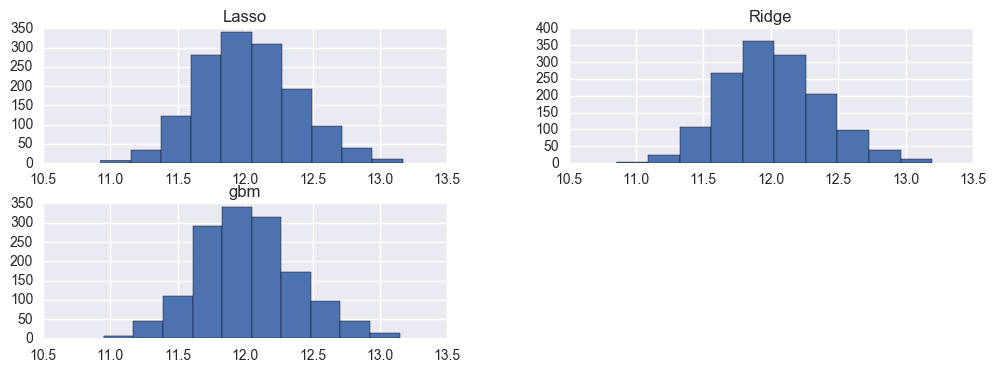

In [483]:
train_meta[['Lasso', 'Ridge', 'gbm']].hist()

In [484]:
train_meta[['Lasso', 'Ridge', 'gbm']].describe()

Lasso        Ridge          gbm
count  1434.000000  1434.000000  1434.000000
mean     12.019740    12.019325    12.019448
std       0.363870     0.364994     0.360235
min      10.926054    10.856780    10.952006
25%      11.768820    11.770682    11.774221
50%      11.999482    11.998730    11.997550
75%      12.256966    12.257138    12.245650
max      13.168440    13.196831    13.145546

### STEP 3:
#### Fit each base model to the full training dataset and make predictions on the test dataset. Store these predictions inside test_meta

In [485]:
ridge.fit(train_meta[features], output)
lasso.fit(train_meta[features], output)
gbm.fit(train_meta[features], output)
test_meta.loc[:,'Ridge'] = ridge.predict(test_meta[features])
test_meta.loc[:,'Lasso'] = lasso.predict(test_meta[features])
test_meta.loc[:,'gbm'] = gbm.predict(test_meta[features])

In [486]:
test_meta[['Lasso', 'Ridge', 'gbm']].describe()

Lasso        Ridge          gbm
count  1459.000000  1459.000000  1459.000000
mean     12.012952    12.012335    12.010983
std       0.392534     0.393091     0.386884
min      10.865029    10.928832    10.915200
25%      11.750589    11.742782    11.755316
50%      11.963969    11.960866    11.965734
75%      12.258017    12.254307    12.242886
max      13.599473    13.576045    13.284890

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124001490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d17a050>]], dtype=object)

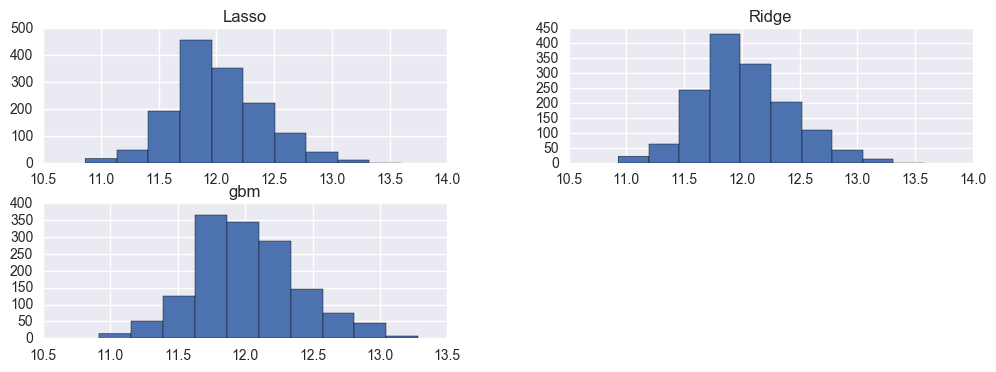

In [487]:
test_meta[['Lasso', 'Ridge', 'gbm']].hist()

### STEP 4:
#### Fit a new model, S (i.e the stacking model) to train_meta, using M1 and M2 as features. Optionally, include other features from the original training dataset or engineered features

In [488]:
train_meta.head(5)

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     4.110874  9.183894            5            7       1924          1950   
1     3.091042  7.427144            6            5       1972          1972   
2     4.110874  8.881975            5            7       1920          1996   
3     4.290459  9.379830            9            5       2003          2004   
4     4.394449  9.467847            6            6       1972          1972   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.000000    5.973810         0.0   5.973810     6.665684  6.856462   
1    5.697093    0.000000         0.0   6.182085     6.182085  6.182085   
2    0.000000    0.000000         0.0   6.274762     6.274762  6.366470   
3    6.333280    7.357556         0.0   5.420535     7.491645  7.491645   
4    0.000000    6.386879         0.0   4.875197     6.584791  6.601230   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  5.609472           0.0   7.108244           1.0      0.000000         1   
1  6.224558           0.0   6.895683           0.0      0.000000         1   
2  6.274762           0.0   7.013915           0.0      0.000000         1   
3  0.000000           0.0   7.491645           1.0      0.000000         2   
4  6.493754           0.0   7.241366           0.0      0.693147         1   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         0             4      0.693147             7           0         1.0   
1         1             2      0.693147             5           1         1.0   
2         0             3      0.693147             6           0         1.0   
3         0             2      0.693147             6           1         3.0   
4         1             3      0.693147             6           1         2.0   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0       392.0    0.000000     0.000000       5.468060        0.0          0.0   
1       288.0    0.000000     0.000000       0.000000        0.0          0.0   
2       288.0    0.000000     0.000000       4.976734        0.0          0.0   
3       874.0    5.332719     3.912023       0.000000        0.0          0.0   
4       497.0    5.686975     4.762174       0.000000        0.0          0.0   

   PoolArea  MoSold  YrSold  MiscFeature_Gar2  MiscFeature_Othr  \
0       0.0       3    2006               0.0               0.0   
1       0.0       6    2006               0.0               0.0   
2       0.0       3    2007               0.0               0.0   
3       0.0       8    2006               0.0               0.0   
4       0.0      12    2009               0.0               0.0   

   MiscFeature_Shed  MiscFeature_TenC  MSSubClass_20  MSSubClass_30  \
0               0.0               0.0              0              0   
1               0.0               0.0              0              0   
2               0.0               0.0              0              0   
3               0.0               0.0              1              0   
4               0.0               0.0              0              0   

   MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  \
0              0              0              1              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              1              0   

   MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              1              0              0              0               0   

In [489]:
train_meta.drop('fold_ID', axis=1, inplace=True)

In [490]:
#features = ['Lasso', 'Ridge', 'gbm']
features = [x for x in train_meta.columns]
features

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'YrSold',
 'MiscFeature_Gar2',
 'MiscFeature_Othr',
 'MiscFeature_Shed',
 'MiscFeature_TenC',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_150',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl'

### Lets use Lasso to fit Stacked Model

In [491]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)

In [492]:
lasso = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [493]:
lasso.fit(train_meta[features], output)

LassoCV(alphas=array([  5.55429e+00,   2.01908e-06, ...,   4.48309e-01,   2.08690e+00]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [494]:
lasso.alpha_

4.2059826854284211e-05

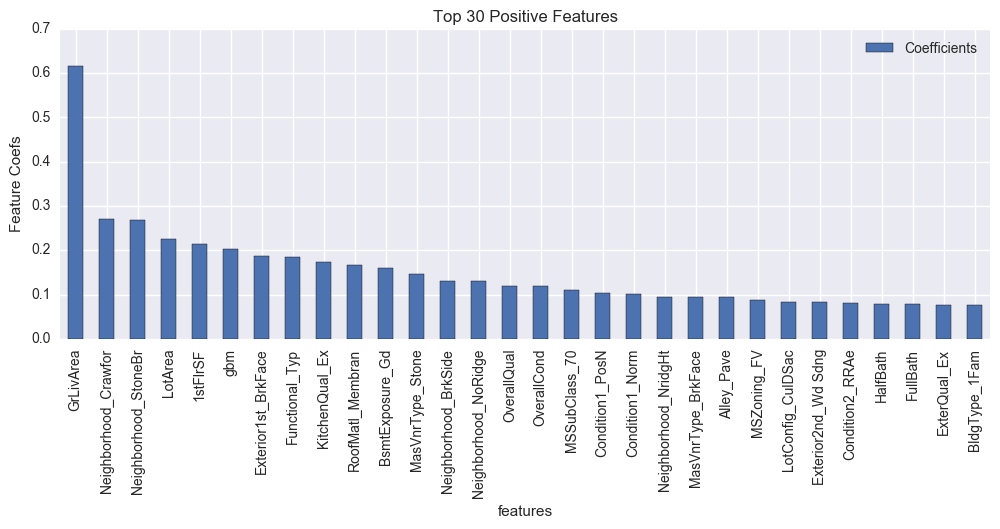

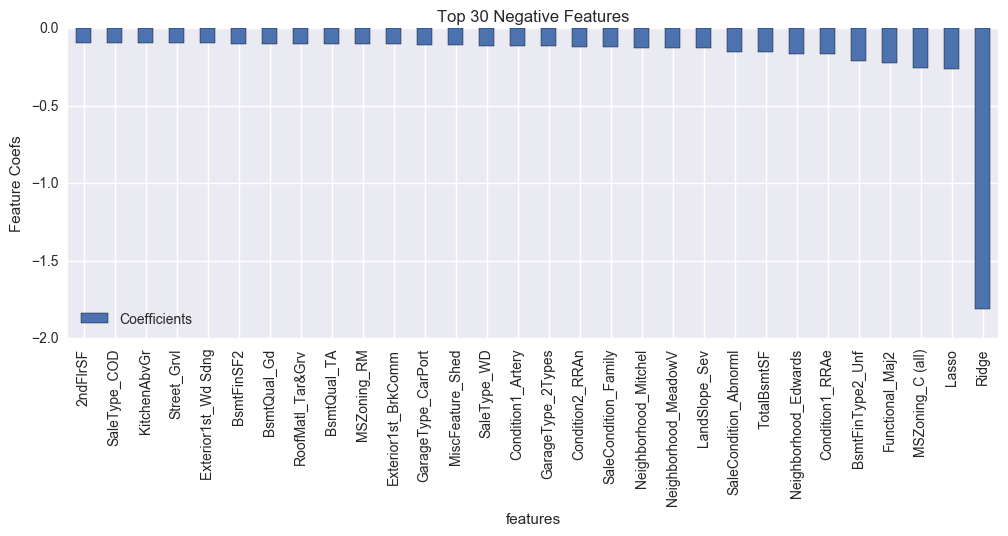

In [495]:
df = {'features': features, 'Coefficients': lasso.coef_}
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

In [496]:
pred = np.expm1(lasso.predict(test_meta[features]))
pred = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
pred.head(5)

Id      SalePrice
0  1461  125450.225417
1  1462  139119.623995
2  1463  189193.712951
3  1464  208932.784239
4  1465  191530.148269

In [497]:
#pred.to_csv('kaggle_submission_stacking_lasso_Jan272017.csv', index=False)

Above did not improve the score! :(

### Lets try ridge to stack

In [498]:
features = ['Lasso', 'Ridge', 'gbm']

In [499]:
ridge = linear_model.RidgeCV(fit_intercept=True, alphas=alpha)

In [500]:
ridge.fit(train_meta[features], output)

RidgeCV(alphas=array([  5.55429e+00,   2.01908e-06, ...,   4.48309e-01,   2.08690e+00]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [501]:
ridge.alpha_

1.8772245203872213

In [502]:
pred = np.expm1(ridge.predict(test_meta[features])[:,0])
pred = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
pred.head(5)

Id      SalePrice
0  1461  124060.702162
1  1462  156665.972057
2  1463  187575.689324
3  1464  201129.294646
4  1465  190457.427090

In [503]:
#pred.to_csv('kaggle_submission_stacking_ridge_Jan272017.csv', index=False)

Above did not improve the score either! :(